In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from functools import reduce
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import quantity_support
from astropy.stats import *
import photutils
from photutils import *

import lacosmic

from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import mixture
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from astroML.linear_model import PolynomialRegression

import pandas as pd

import glob, copy

import astroalign as asa
from statistics import mean
from itertools import chain

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "14",
      "figure.figsize" : [10,5]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [3]:
#function to open files

def read_files(file_names):
    data = []
    
    for file in file_names:
        myfile = fits.open(file)
        data.append(myfile[0].data)
        myfile.close()
        
    return data

## Bias

In [5]:
# read file names:
bias_name = glob.glob('../work/20230110/bias-*.fit')

print(bias_name)
# read file:
bias = read_files(bias_name)

bias

['../work/20230110\\bias-001.fit', '../work/20230110\\bias-002.fit', '../work/20230110\\bias-003.fit', '../work/20230110\\bias-004.fit', '../work/20230110\\bias-005.fit']


[array([[1299, 1262, 1310, ..., 1371, 1381, 1350],
        [1340, 1391, 1392, ..., 1410, 1384, 1388],
        [1355, 1361, 1354, ..., 1377, 1364, 1397],
        ...,
        [1377, 1378, 1397, ..., 1370, 1366, 1399],
        [1368, 1383, 1384, ..., 1369, 1370, 1366],
        [1389, 1367, 1373, ..., 1363, 1385, 1401]], dtype=uint16),
 array([[1312, 1311, 1352, ..., 1389, 1362, 1375],
        [1397, 1386, 1386, ..., 1367, 1392, 1384],
        [1374, 1359, 1370, ..., 1372, 1414, 1382],
        ...,
        [1371, 1393, 1381, ..., 1386, 1370, 1374],
        [1393, 1357, 1390, ..., 1367, 1346, 1398],
        [1392, 1345, 1389, ..., 1374, 1370, 1404]], dtype=uint16),
 array([[1318, 1290, 1344, ..., 1370, 1361, 1392],
        [1354, 1360, 1384, ..., 1388, 1350, 1371],
        [1370, 1370, 1386, ..., 1385, 1366, 1377],
        ...,
        [1408, 1381, 1391, ..., 1380, 1384, 1380],
        [1383, 1377, 1398, ..., 1407, 1360, 1382],
        [1391, 1392, 1382, ..., 1389, 1349, 1388]], dtype=uint

shape bias vector: (5, 2200, 2750)
shape of mean bias: (2200, 2750)


Text(0.5, 1.0, 'Mean bias frame')

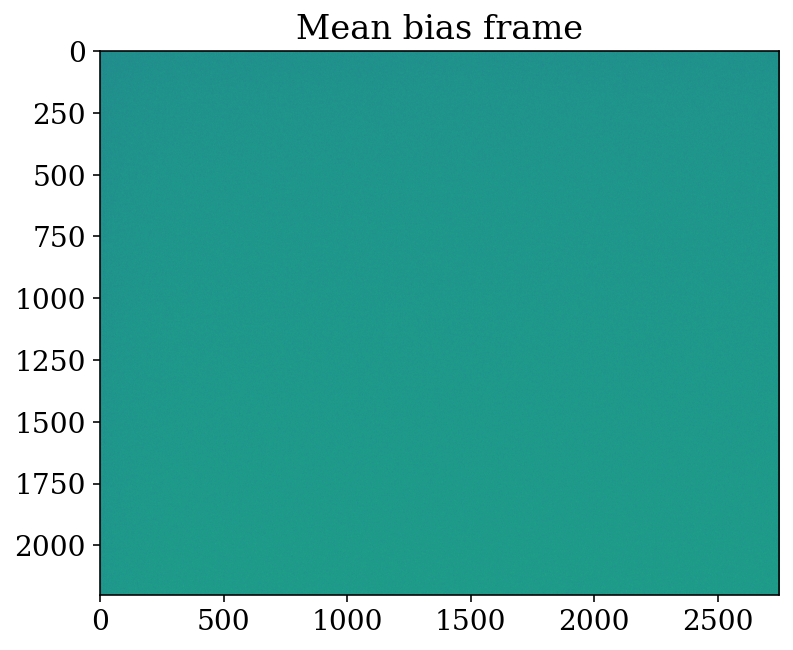

In [7]:
#mean of the bias:

bias = np.array(bias)
print('shape bias vector:', bias.shape)

meanbias = np.mean(bias, axis=0)
print('shape of mean bias:', meanbias.shape)

plt.imshow(meanbias, clim=(1300, 1450))
plt.title('Mean bias frame')

In [8]:
# save as a fits file the bias
hdu_bias = fits.PrimaryHDU(meanbias)
hdul_bias = fits.HDUList([hdu_bias])
hdul_bias.writeto('mean_bias_spectro_NGC956.fits', overwrite=True)

## Flat

In [9]:
# read file names:
flat_name = glob.glob('../work/20230110/flat*.fit')

print(flat_name)
# read file:
flat = read_files(flat_name)

flat

['../work/20230110\\flat60sec-001.fit', '../work/20230110\\flat60sec-002.fit', '../work/20230110\\flat60sec-003.fit', '../work/20230110\\flat60sec-004.fit', '../work/20230110\\flat60sec-005.fit']


[array([[1678, 1652, 1715, ..., 1395, 1363, 1379],
        [1769, 1772, 1796, ..., 1366, 1379, 1353],
        [1746, 1725, 1817, ..., 1374, 1384, 1365],
        ...,
        [1746, 1694, 1678, ..., 1356, 1397, 1390],
        [1674, 1721, 1792, ..., 1372, 1408, 1394],
        [1689, 1653, 1735, ..., 1407, 1389, 1385]], dtype=uint16),
 array([[1715, 1675, 1671, ..., 1398, 1372, 1360],
        [1755, 1755, 1794, ..., 1366, 1371, 1368],
        [1718, 1747, 1816, ..., 1384, 1386, 1364],
        ...,
        [1680, 1733, 1755, ..., 1371, 1378, 1368],
        [1703, 1684, 1727, ..., 1376, 1381, 1421],
        [1706, 1693, 1730, ..., 1404, 1397, 1378]], dtype=uint16),
 array([[1605, 1731, 1727, ..., 1373, 1359, 1381],
        [1731, 1742, 1758, ..., 1394, 1373, 1407],
        [1759, 1755, 1772, ..., 1357, 1342, 1369],
        ...,
        [1670, 1677, 1709, ..., 1400, 1411, 1389],
        [1715, 1664, 1653, ..., 1363, 1383, 1344],
        [1637, 1665, 1691, ..., 1402, 1365, 1362]], dtype=uint

(5, 2200, 2750)
(2200, 2750)


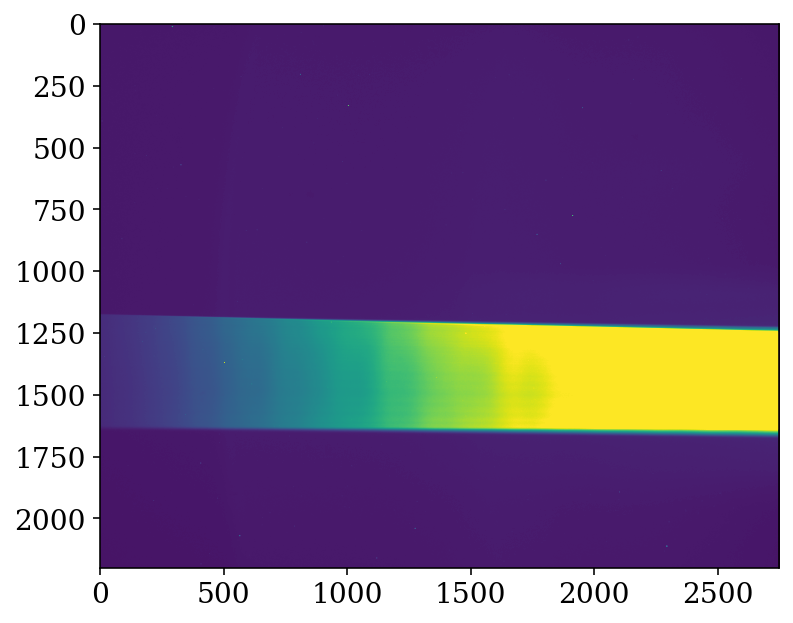

In [10]:
# subtract the bias
flat_nb = flat-meanbias

# avg the flat
flat_nb = np.array(flat_nb)
print(flat_nb.shape)

mean_flat = np.mean(flat_nb, axis=0)
print(mean_flat.shape)

plt.imshow(mean_flat, clim=[0,6000])

### Edges detection

1232.6644324628094
(2200, 2750)
1379.573404694214
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


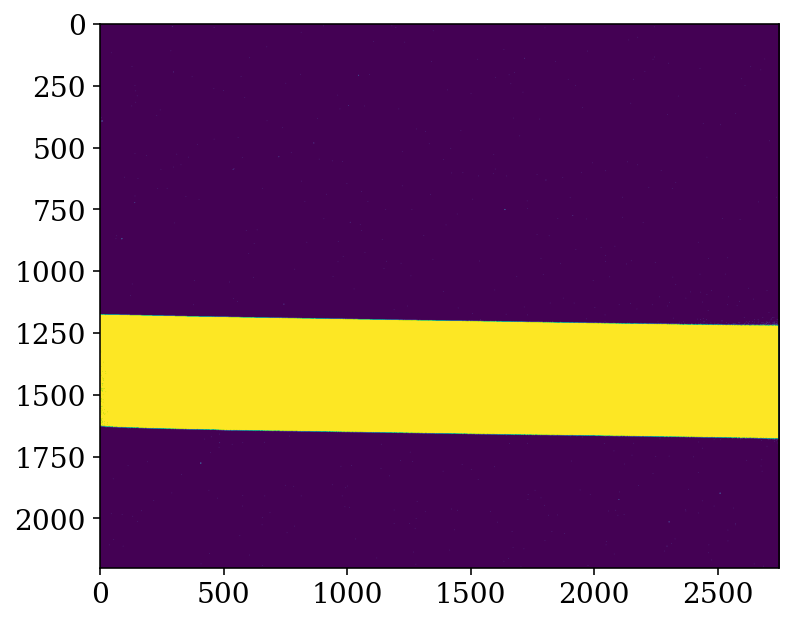

In [11]:
avg = np.mean(mean_flat)
print(avg)

print(mean_flat.shape)

#line tracer
zero_line = np.zeros(mean_flat.shape)

lines = np.arange(0,2199,1)
columns = np.arange(0,2749,1)

bias_mean = np.mean(meanbias)
print(bias_mean)

for line in lines:
    for col in columns:
        if(mean_flat[line,col]>bias_mean-700):
            zero_line[line,col]=1
        

print(zero_line)
plt.imshow(zero_line)

In [12]:
print(mean_flat.shape)
xrange = np.arange(0, mean_flat.shape[1])
yrange = np.arange(0, mean_flat.shape[0])

edge = []
for x,y in zip(xrange, yrange):
    if(zero_line[x,y] == 1):
        coord = [x,y]
        edge.append(coord)
        
        
print(edge)

(2200, 2750)
[[1196, 1196], [1197, 1197], [1198, 1198], [1199, 1199], [1200, 1200], [1201, 1201], [1202, 1202], [1203, 1203], [1204, 1204], [1205, 1205], [1206, 1206], [1207, 1207], [1208, 1208], [1209, 1209], [1210, 1210], [1211, 1211], [1212, 1212], [1213, 1213], [1214, 1214], [1215, 1215], [1216, 1216], [1217, 1217], [1218, 1218], [1219, 1219], [1220, 1220], [1221, 1221], [1222, 1222], [1223, 1223], [1224, 1224], [1225, 1225], [1226, 1226], [1227, 1227], [1228, 1228], [1229, 1229], [1230, 1230], [1231, 1231], [1232, 1232], [1233, 1233], [1234, 1234], [1235, 1235], [1236, 1236], [1237, 1237], [1238, 1238], [1239, 1239], [1240, 1240], [1241, 1241], [1242, 1242], [1243, 1243], [1244, 1244], [1245, 1245], [1246, 1246], [1247, 1247], [1248, 1248], [1249, 1249], [1250, 1250], [1251, 1251], [1252, 1252], [1253, 1253], [1254, 1254], [1255, 1255], [1256, 1256], [1257, 1257], [1258, 1258], [1259, 1259], [1260, 1260], [1261, 1261], [1262, 1262], [1263, 1263], [1264, 1264], [1265, 1265], [1266,

### Davide's way

In [13]:
#This cell will take the column of pixel at x=90% of total width (as it is a portion bright enough but not extreme, as in the very end of the image there is no data), and compute the y span in which to find upper and lower boundary
sopra=[]
sotto=[]
window_y=6
window_x=10
span=[window_y,mean_flat.shape[0]-window_y]
print(span)

x_high = int(mean_flat.shape[1]*0.95)
diff = []
for y in range(span[0],span[1]):
        diff.append(np.array(mean_flat[y-window_y:y,x_high-window_x:x_high]).mean()-np.array(mean_flat[y-window_y+1:y+1,x_high-window_x:x_high]).mean())
span=[np.array(diff).argmin(),np.array(diff).argmax()]
span_orig=copy.copy(span)
sopra.extend([(x_high,span[0])]*8)
sotto.extend([(x_high,span[1])]*8)


[6, 2194]


In [14]:
#from the x at 90% previously found, this cell move to the left in x axis and find the upper and lower boundary, contraining that they has to be in an interval of the median of the previous 8 points to avoid outliers
for x in reversed(range(0,x_high)):
    diff = []
    for y in chain(range(span[0]-30,span[0]+30),range(span[1]-30,span[1]+30)):
        diff.append(np.array(mean_flat[y-window_y:y,x]).mean()-np.array(mean_flat[y-window_y+1:y+1,x]).mean())

    sopra.extend([(x,np.array(diff).argmin()+span[0]-30)])
    sotto.extend([(x,np.array(diff).argmax()+span[0]-30+(span[1]-span[0]-60))])

    span=[int(np.median(np.array(sopra)[-8:-1,1])),int(np.median(np.array(sotto)[-8:-1,1]))]

In [15]:
#this cell compute the rest, so the same thing from x=90%width to the end of the image
span=copy.copy(span_orig)
sopra_high=[]
sotto_high=[]
sopra_high.extend([(x_high,span[0])]*8)
sotto_high.extend([(x_high,span[1])]*8)

for x in range(x_high,mean_flat.shape[1]):
    diff = []
    for y in chain(range(span[0]-30,span[0]+30),range(span[1]-30,span[1]+30)):

        diff.append(np.array(mean_flat[y-window_y:y,x]).mean()-np.array(mean_flat[y-window_y+1:y+1,x]).mean())

    sopra_high.extend([(x,np.array(diff).argmin()+span[0]-30)])
    sotto_high.extend([(x,np.array(diff).argmax()+span[0]-30+(span[1]-span[0]-60))])

    span=[int(np.median(np.array(sopra_high)[-8:-1,1])),int(np.median(np.array(sotto_high)[-8:-1,1]))]

sopra.extend(sopra_high)
sotto.extend(sotto_high)
sopra.sort()
sotto.sort()

In [16]:
#this cell corrects the outliers, so if the difference between two consecutive points is too high, it takes the value of the previous point
for i in range(len(sopra)-1):
    if (abs(sopra[i][1]-sopra[i+1][1])>15):
        sopra[i+1]=(sopra[i+1][0],sopra[i][1])
    if (abs(sotto[i][1]-sotto[i+1][1])>15):
        sotto[i+1]=(sotto[i+1][0],sotto[i][1])

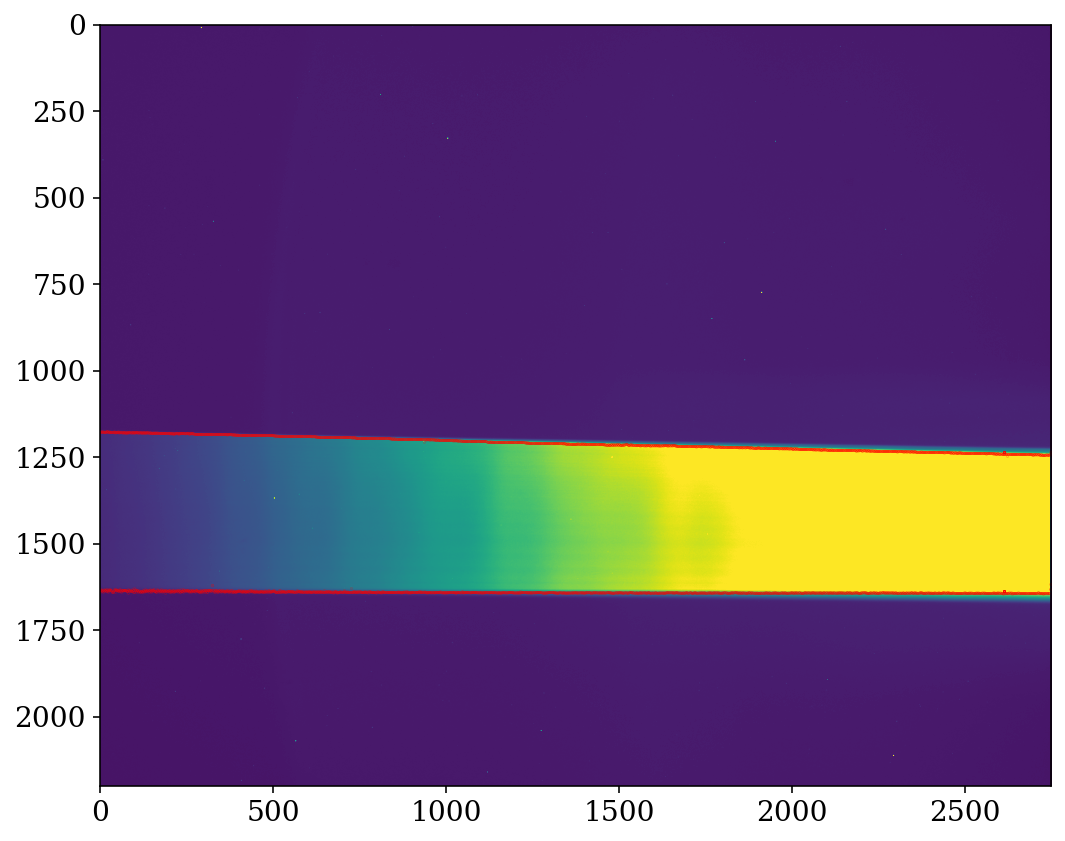

In [17]:
#plot sopra and sotto as scatterplot
plt.figure(figsize=(10,7))
plt.imshow(mean_flat,clim=[0,6000])
plt.scatter(*zip(*sopra),s=0.01,c='r')
plt.scatter(*zip(*sotto),s=0.01,c='r')

In [18]:
#print(sopra)
print(sotto)
print(mean_flat[yrange[-1]][xrange[-1]])


[(0, 1639), (1, 1635), (2, 1630), (3, 1633), (4, 1635), (5, 1636), (6, 1637), (7, 1634), (8, 1633), (9, 1640), (10, 1630), (11, 1633), (12, 1636), (13, 1633), (14, 1635), (15, 1633), (16, 1637), (17, 1637), (18, 1631), (19, 1633), (20, 1638), (21, 1631), (22, 1639), (23, 1636), (24, 1635), (25, 1631), (26, 1635), (27, 1634), (28, 1632), (29, 1634), (30, 1634), (31, 1636), (32, 1633), (33, 1635), (34, 1640), (35, 1639), (36, 1639), (37, 1637), (38, 1639), (39, 1632), (40, 1634), (41, 1634), (42, 1632), (43, 1639), (44, 1633), (45, 1632), (46, 1634), (47, 1635), (48, 1635), (49, 1634), (50, 1633), (51, 1637), (52, 1634), (53, 1637), (54, 1638), (55, 1632), (56, 1634), (57, 1634), (58, 1632), (59, 1638), (60, 1637), (61, 1639), (62, 1634), (63, 1634), (64, 1633), (65, 1633), (66, 1636), (67, 1634), (68, 1633), (69, 1635), (70, 1635), (71, 1634), (72, 1635), (73, 1634), (74, 1637), (75, 1633), (76, 1633), (77, 1636), (78, 1636), (79, 1637), (80, 1632), (81, 1634), (82, 1642), (83, 1634), (

In [19]:
upper_edge = np.array(sopra)
upper_edge = upper_edge.T

lower_edge = np.array(sotto)
lower_edge = lower_edge.T

print(upper_edge.shape)
print(lower_edge.shape)

(2, 2766)
(2, 2766)


In [20]:
print(upper_edge[1][0])
print(lower_edge[1])

1176
[1639 1635 1630 ... 1617 1616 1616]


(array([339], dtype=int64), array([2747], dtype=int64))


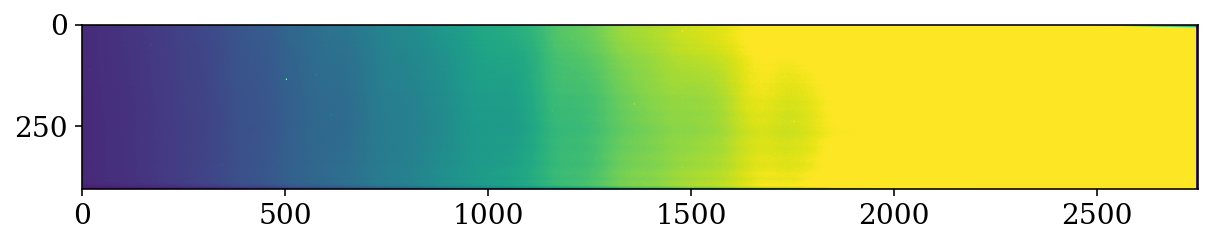

In [40]:
trace_mask = (yrange>upper_edge[1][-1]) & (yrange<lower_edge[1][0])

trace = mean_flat[trace_mask]

print(np.where(trace==0))

plt.imshow(trace, clim=(0,6000))

trace = np.zeros((len(yrange),len(xrange)))
for x in xrange:
    for y in range(upper_edge[1][0], lower_edge[1][0]):
        if((y>=upper_edge[1][y]) & (y<=lower_edge[1][y])):
            trace[y][x] = (mean_flat[y][x])


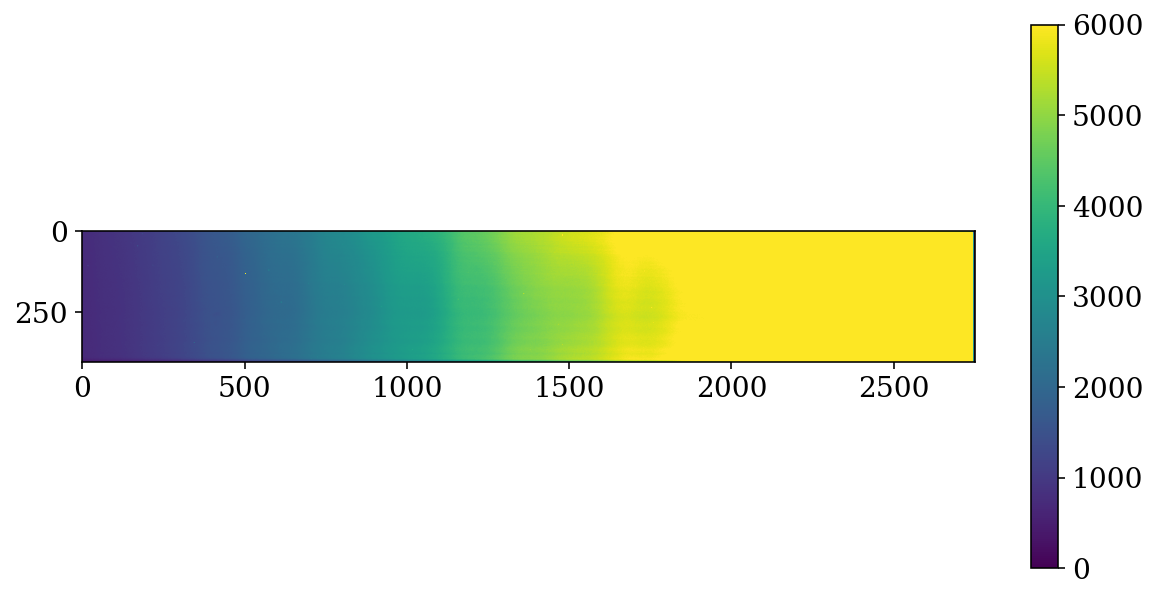

In [41]:
plt.imshow(trace, clim=[0,6000])
plt.colorbar()

### Normalize the flat

4424.779574437445
(array([339], dtype=int64), array([2747], dtype=int64))


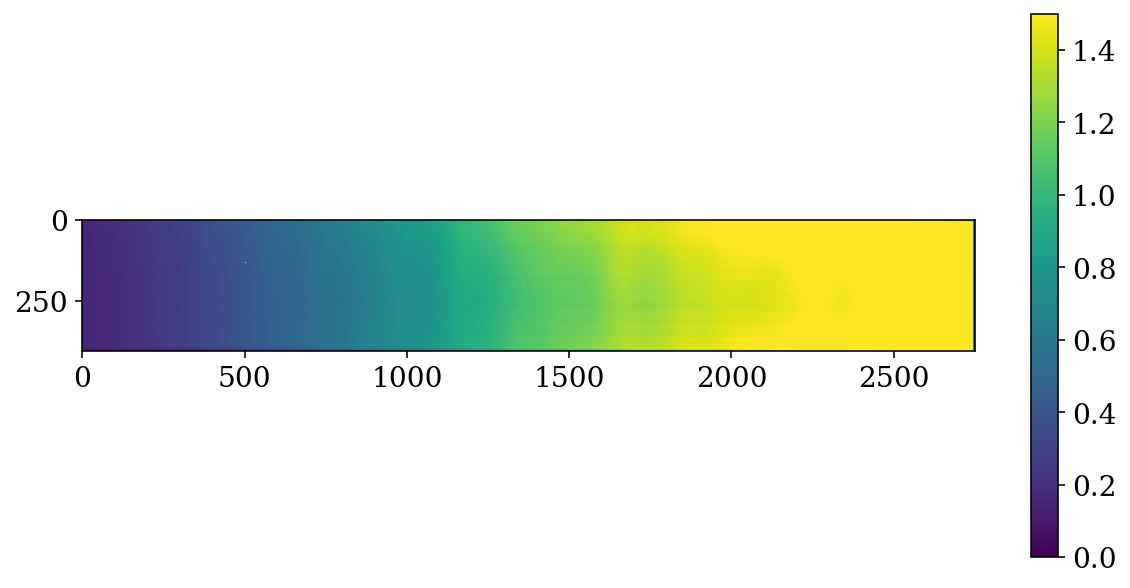

In [42]:
flat_mean = np.mean(trace)
norm_flat = trace / flat_mean

print(flat_mean)

print(np.where(norm_flat==0))

plt.imshow(norm_flat, clim=(0,1.5))
plt.colorbar()

## Data

def trace(upper, lower, data):
    
    sci_trace = np.zeros((len(yrange),len(xrange)))
    
    for x in xrange:
        for y in range(upper[1][0], lower[1][0]):
            if((y>=upper[1][y]) & (y<=lower[1][y])):
                sci_trace[y][x] = (data[y][x])
    
    return sci_trace

In [24]:
def data_reduction(data, exp_time):
    #subtract the bias and divide by the flat
    data_nb = data - meanbias[trace_mask]
    data_normflat = data_nb / norm_flat
    
    #conversion in e/s
    data_es = data_normflat * 0.6 / exp_time
    
    return data_es

## Wavelength Calibration

In [25]:
arc_names = glob.glob('../work/20230110/arc*.fit')
arc = read_files(arc_names)
arc1 = arc[0]

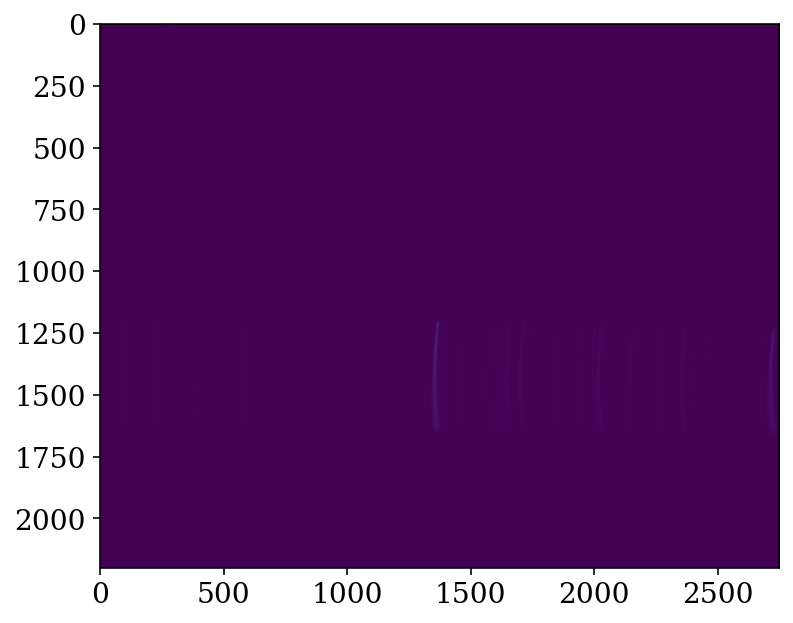

In [27]:
plt.imshow(arc1)

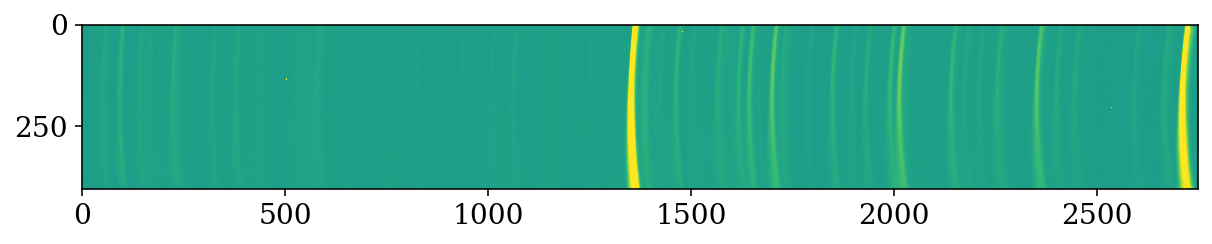

In [28]:
#define the trace
arc1_trace = arc1[trace_mask]
plt.imshow(arc1_trace, clim=(0,2500))

<ipython-input-24-869aaf23c345>:4: RuntimeWarning: divide by zero encountered in true_divide
  data_normflat = data_nb / norm_flat


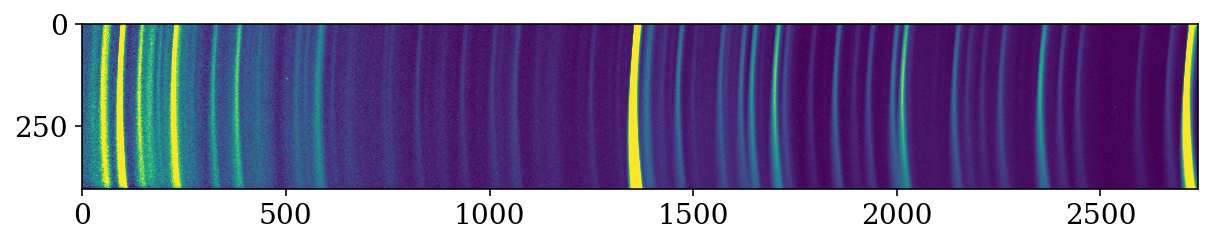

In [106]:
# data reduction
arc1_red = data_reduction(arc1_trace, 20)
plt.imshow(arc1_red[:,:2740], clim=(0,15))

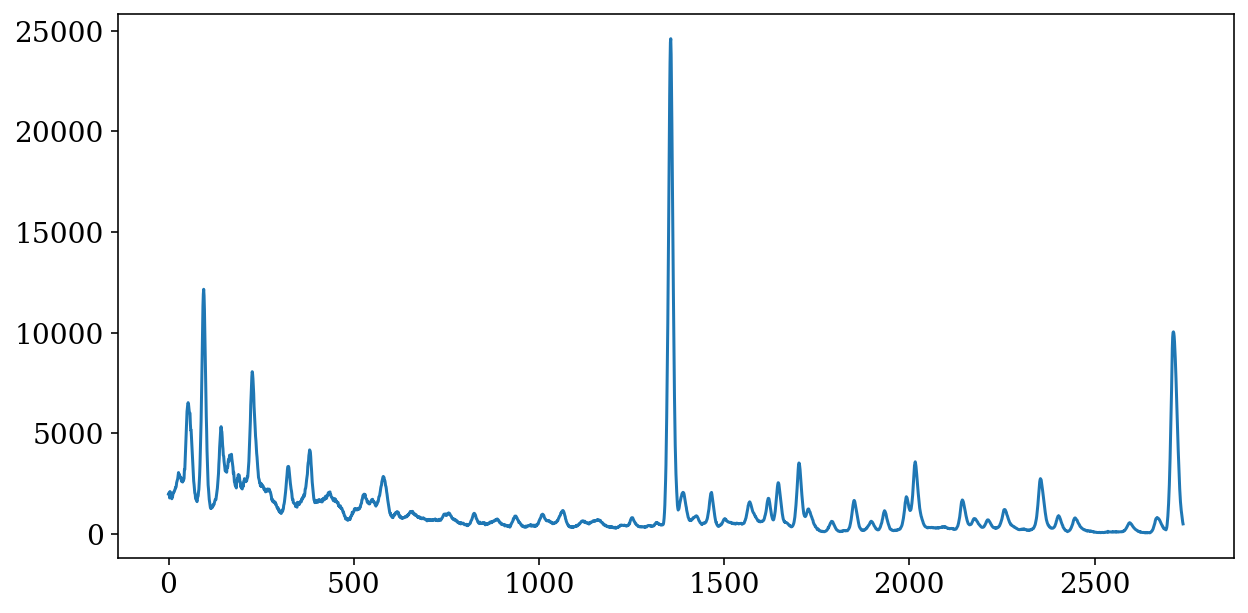

In [107]:
#extract the 1D spectrum:
arc_spct1D = np.sum(arc1_red[:,:2740], axis=0)
plt.plot(arc_spct1D)

In [108]:
known_wl = np.array([4764.665, 4879.664, 5852.488, 6143.063, 6402.246, 6678.276])

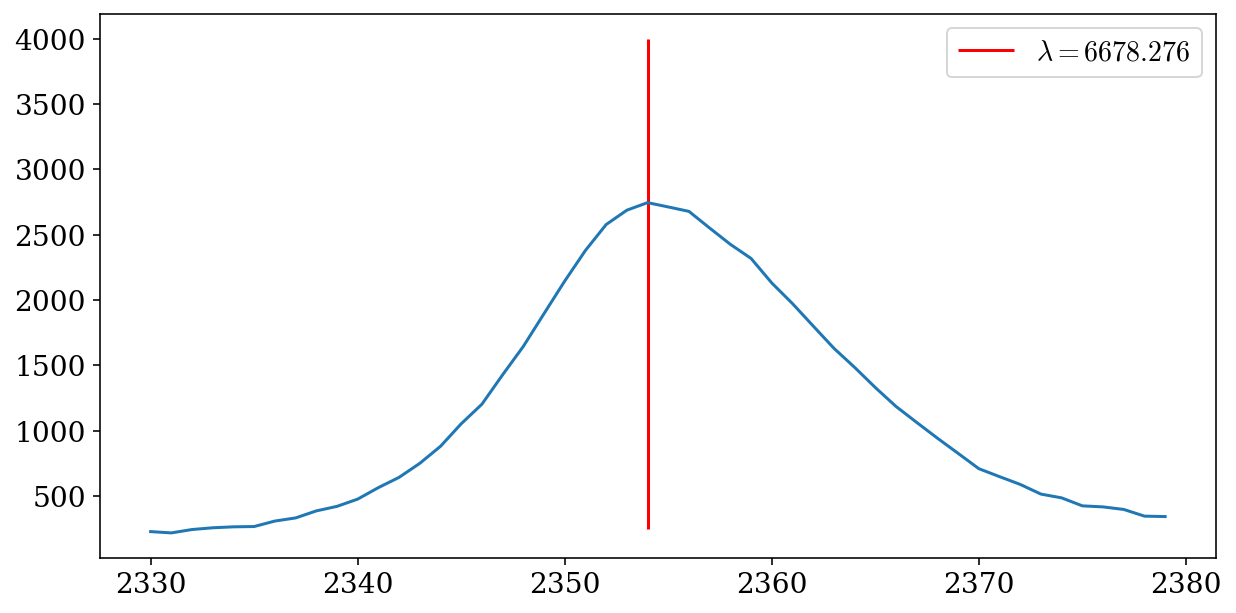

In [109]:
plt.plot(xrange[2330:2380], arc_spct1D[2330:2380])
plt.vlines(2354, 250, 4000, label='$\lambda=6678.276$', colors='r')
plt.legend()

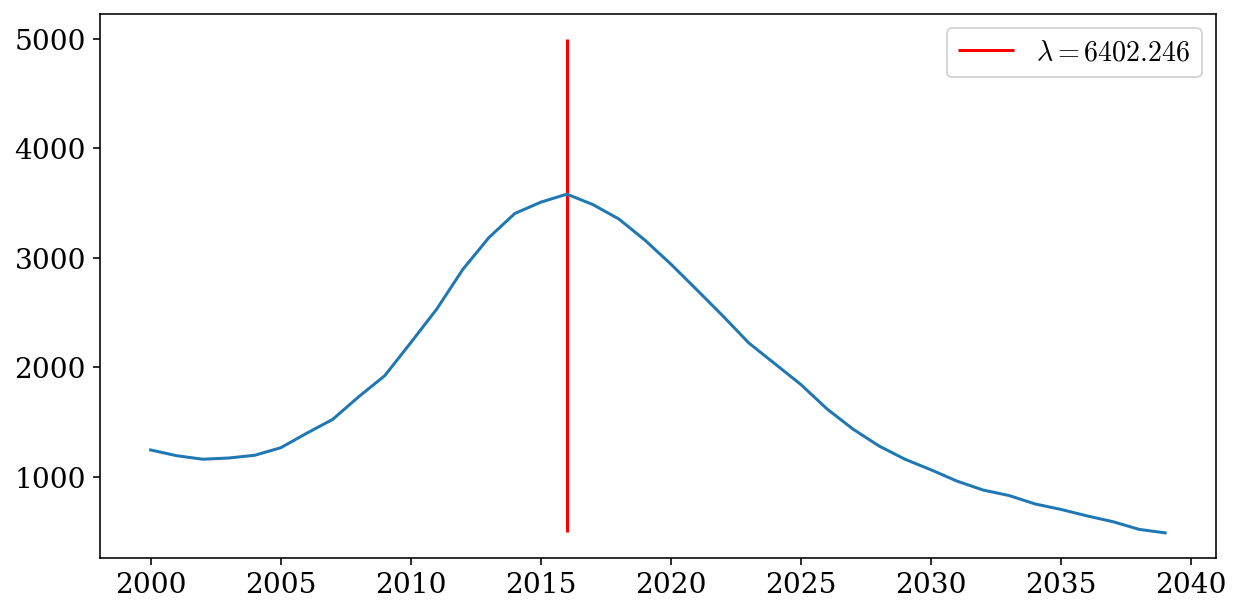

In [110]:
plt.plot(xrange[2000:2040], arc_spct1D[2000:2040])
plt.vlines(2016, 500, 5000, label='$\lambda=6402.246$', colors='r') #1990
plt.legend()

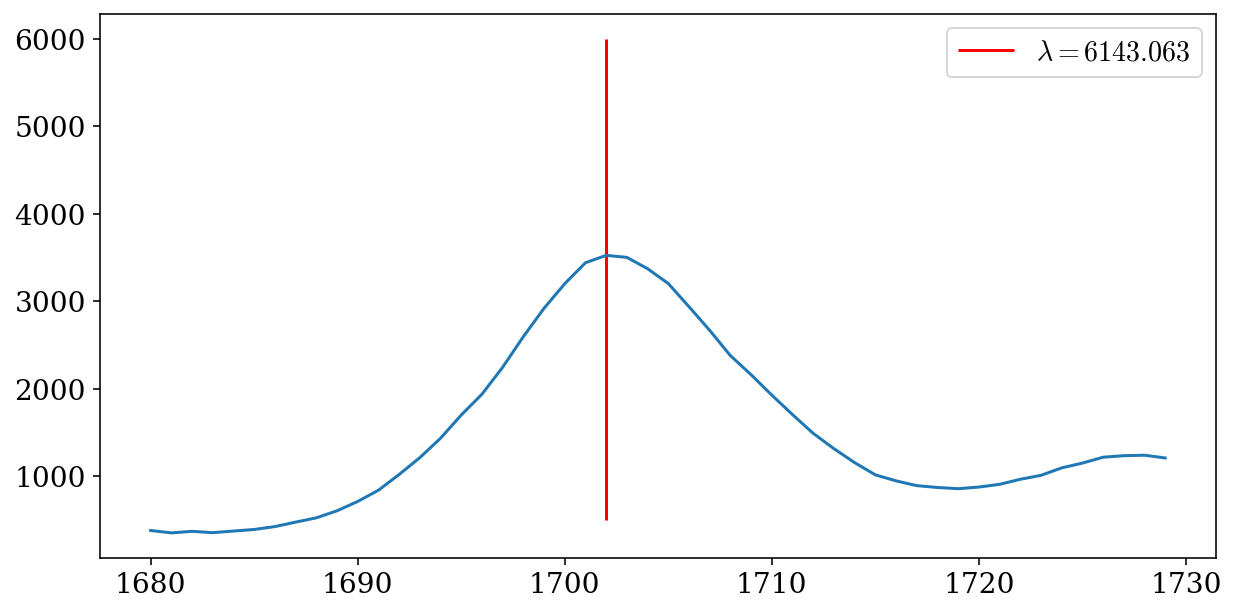

In [111]:
plt.plot(xrange[1680:1730], arc_spct1D[1680:1730])
plt.vlines(1702, 500, 6000, label='$\lambda=6143.063$', colors='r')#1677
plt.legend()

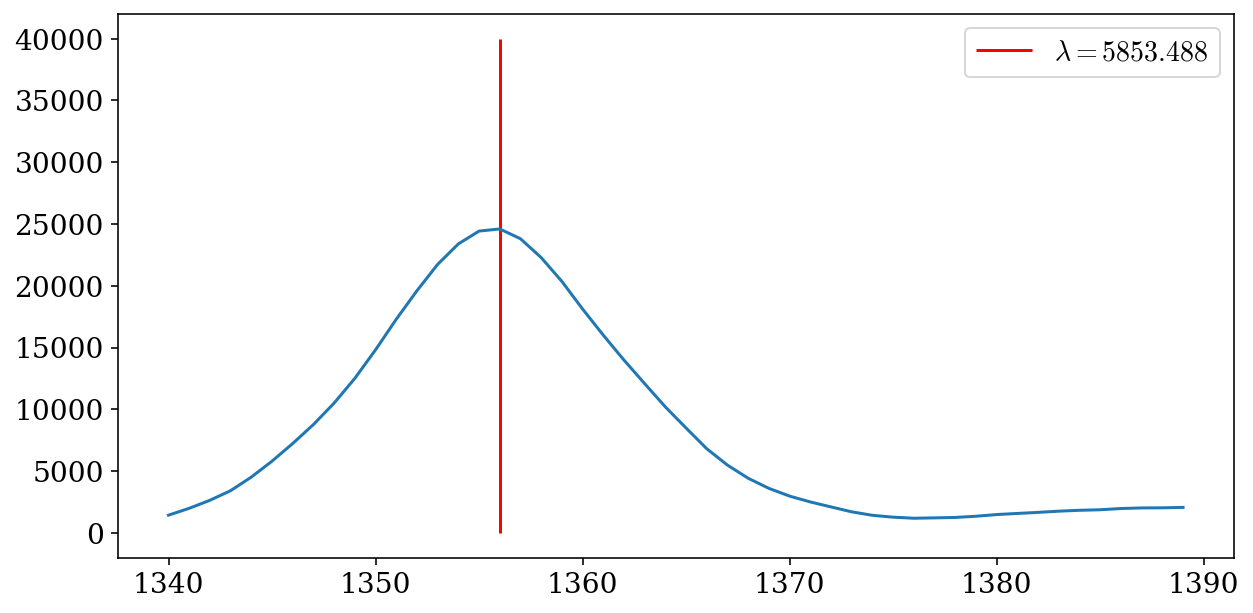

In [112]:
# find the right pixels:
plt.plot(xrange[1340:1390], arc_spct1D[1340:1390])
plt.vlines(1356, 0, 40000, label='$\lambda=5853.488$', colors='r')#1330
plt.legend()

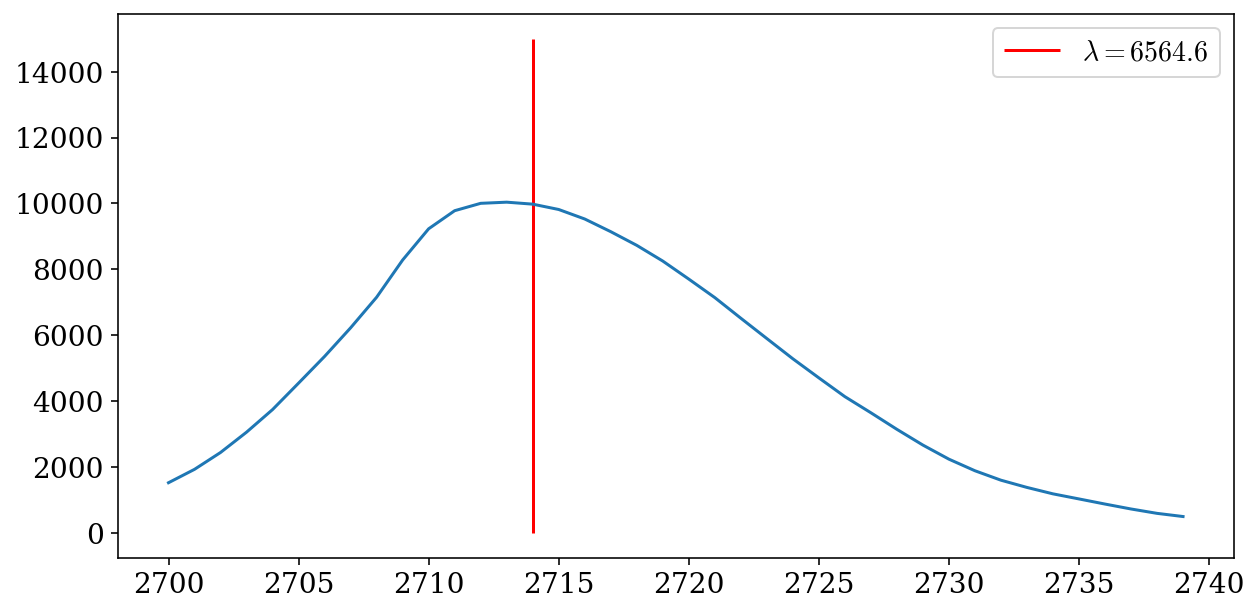

In [113]:
plt.plot(xrange[2700:2740], arc_spct1D[2700:2740])
plt.vlines(2714, 0, 15000, label='$\lambda=6564.6$', colors='r')#2689
plt.legend()

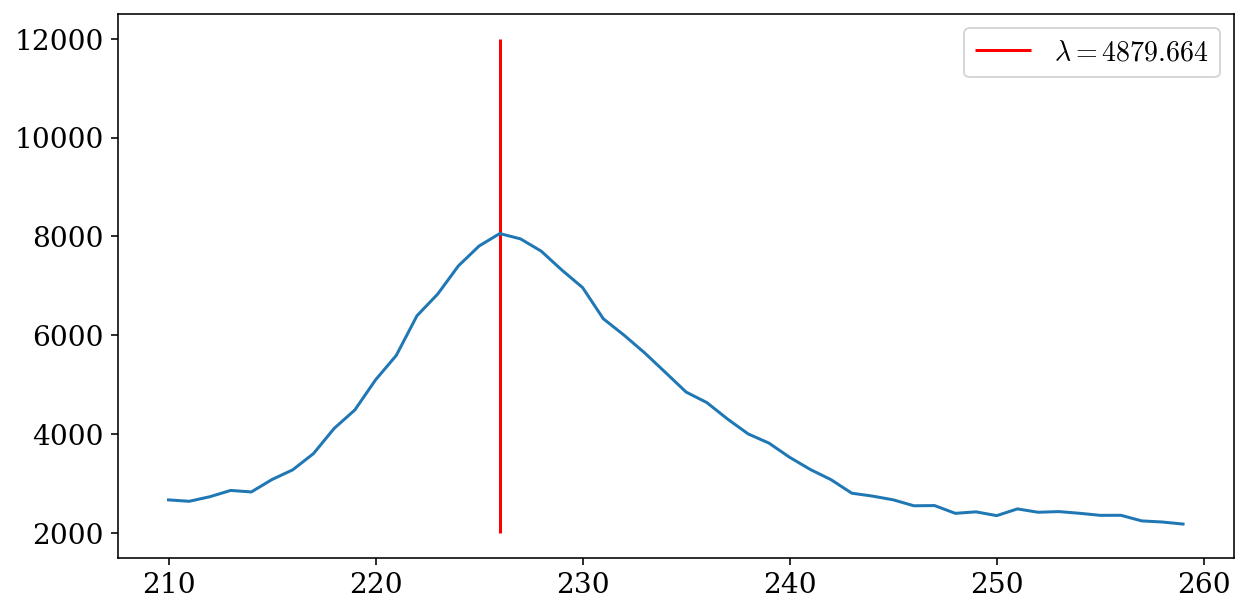

In [114]:
plt.plot(xrange[210:260], arc_spct1D[210:260])
plt.vlines(226, 2000, 12000, label='$\lambda=4879.664$', colors='r')#198
plt.legend()

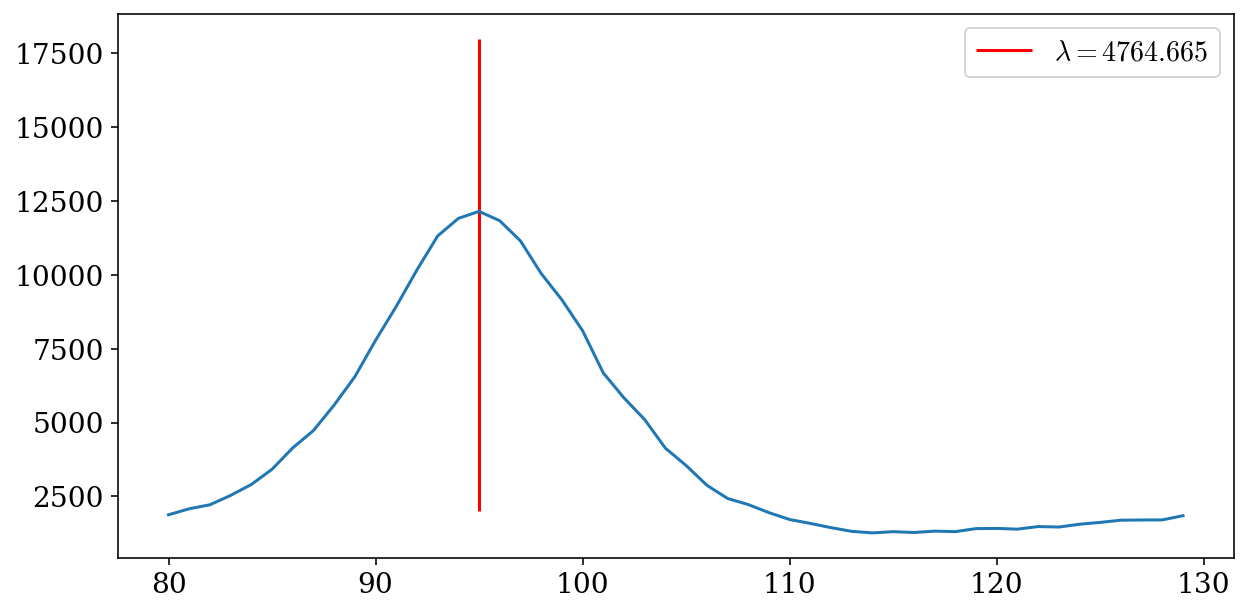

In [115]:
plt.plot(xrange[80:130], arc_spct1D[80:130])
plt.vlines(95, 2000,18000, label='$\lambda=4764.665$', colors='r')#67
plt.legend()

In [116]:
pix_line = np.array([95, 226, 1356, 1702, 2016, 2354])

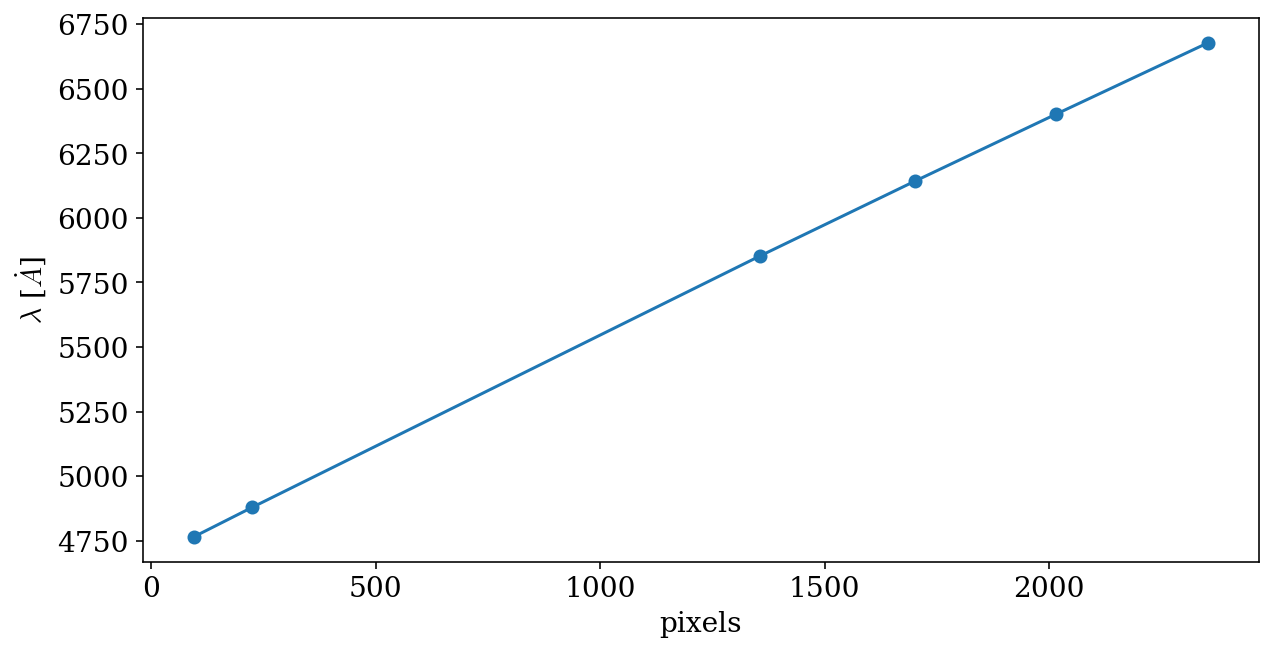

In [117]:
plt.plot(pix_line, known_wl)
plt.scatter(pix_line, known_wl)
plt.xlabel('pixels')
plt.ylabel('$\lambda$ [$\dot{A}$]')
plt.show()

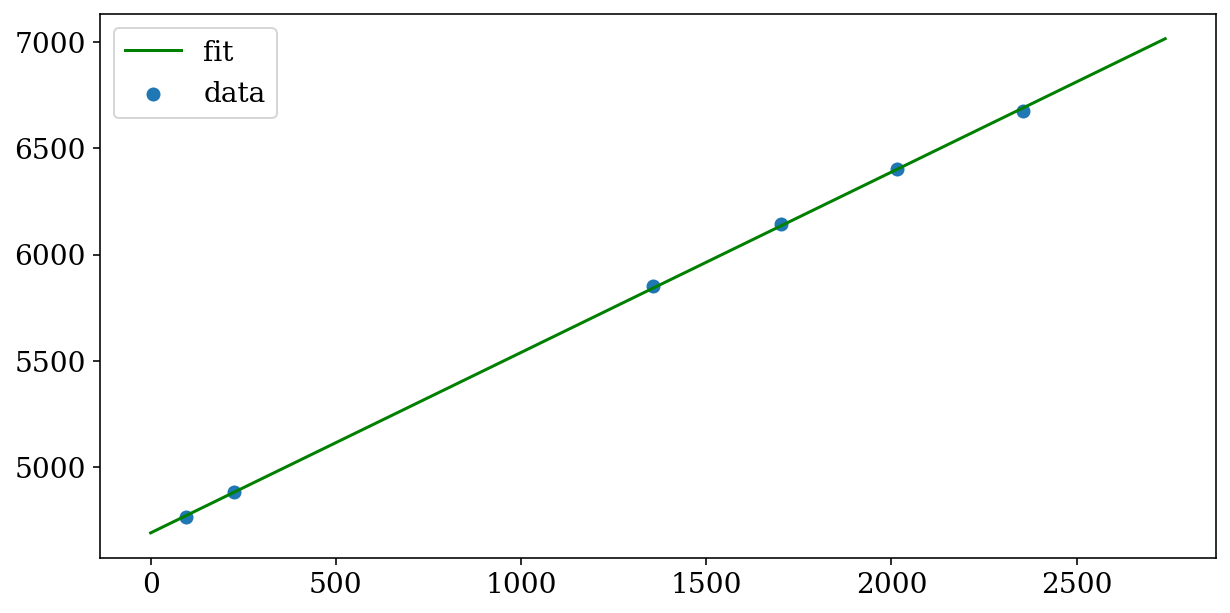

In [118]:
# construct the wave model
wl_calib = np.polyfit(pix_line, known_wl, 1)
wfnc = np.poly1d(wl_calib)
#ipix = np.arange(ny/2)
wave = wfnc(xrange[:2740])

plt.plot(wave, color='g', label='fit')
plt.scatter(pix_line, known_wl, label='data')
plt.legend()

In [119]:
wfnc

poly1d([8.49711401e-01, 4.68933139e+03])

### Standard star

In [120]:
std_star_name = glob.glob('../work/20230110/HD3360*.fit')
std_star = read_files(std_star_name)
std_star = std_star[0]

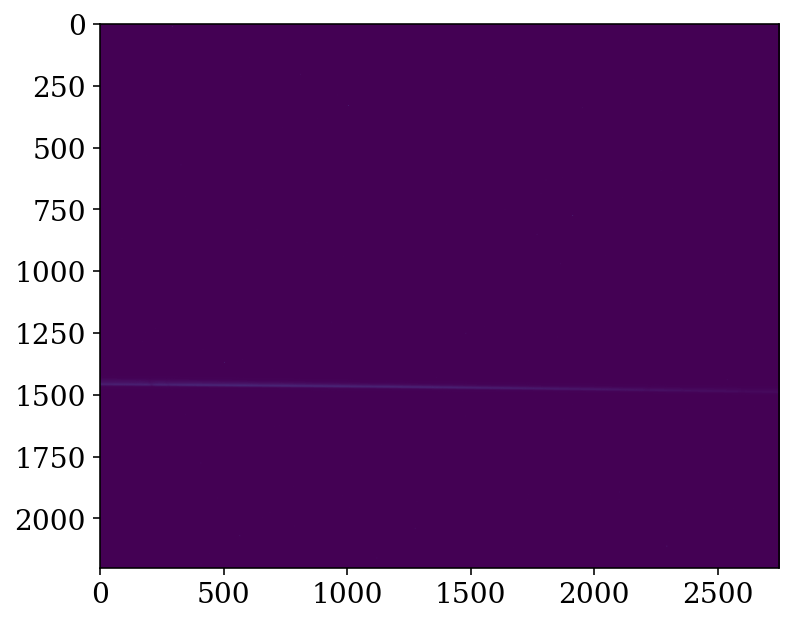

In [121]:
plt.imshow(std_star)

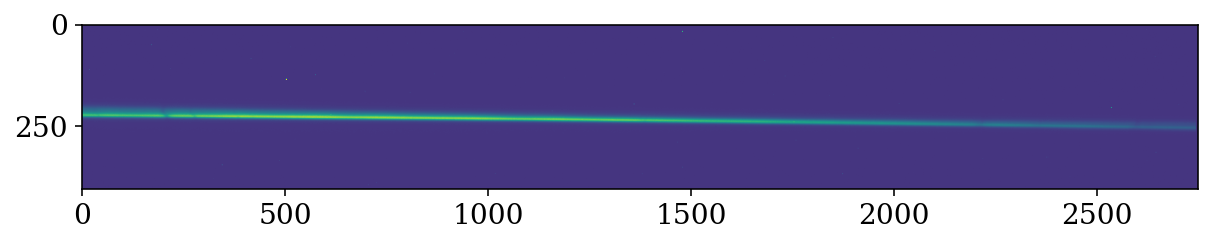

In [122]:
# define the trace

std_star_trace = std_star[trace_mask]
plt.imshow(std_star_trace, clim=(0, 9000))

<ipython-input-24-869aaf23c345>:4: RuntimeWarning: divide by zero encountered in true_divide
  data_normflat = data_nb / norm_flat


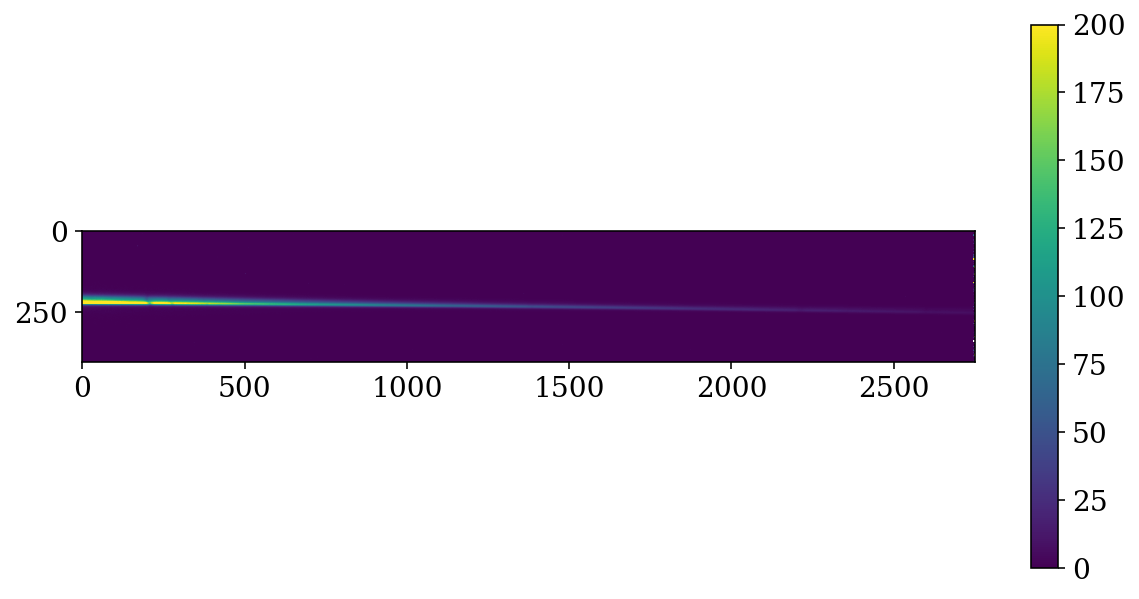

In [123]:
# data reduction:

std_star_red = data_reduction(std_star_trace, 60)

plt.imshow(std_star_red, clim=(0,200))
plt.colorbar()

In [124]:
# compute the meansky:
skymod1 = np.median(std_star_red[0:100,:])
skymod2 = np.median(std_star_red[std_star_red.shape[0]-100,:])

print(skymod1,skymod2)

skymod = (skymod1+skymod2)/2

print('mean_sky = ', skymod)

0.002833309593763797 0.050884429751469826
mean_sky =  0.02685886967261681


In [126]:
# construct sky model in 2D:
print(std_star_red.shape)

nx,ny = std_star_red.shape
sky2d = np.transpose(np.tile(skymod, (ny,404)))
sky2d.shape

(404, 2750)


(404, 2750)

0.0


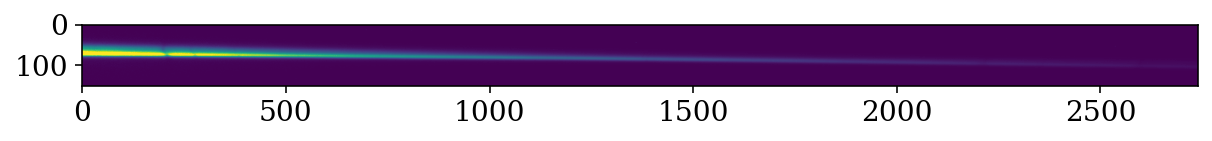

In [138]:
#subtract the mean sky:
std_star_clean = std_star_red - sky2d

skymod1 = np.median(std_star_clean[0:100,:])
skymod2 = np.median(std_star_clean[std_star_clean.shape[0]-100,:])

meansky = (skymod1+skymod2)/2
print(meansky)

plt.imshow(std_star_clean[150:300,:2740], clim=(0,200))

In [139]:
# save file

hdu_std_star = fits.PrimaryHDU(std_star_clean)
hdul_std_star = fits.HDUList([hdu_std_star])
hdul_std_star.writeto('std_star_NGC.fits', overwrite=True)

Text(0, 0.5, 'Flux [e/s]')

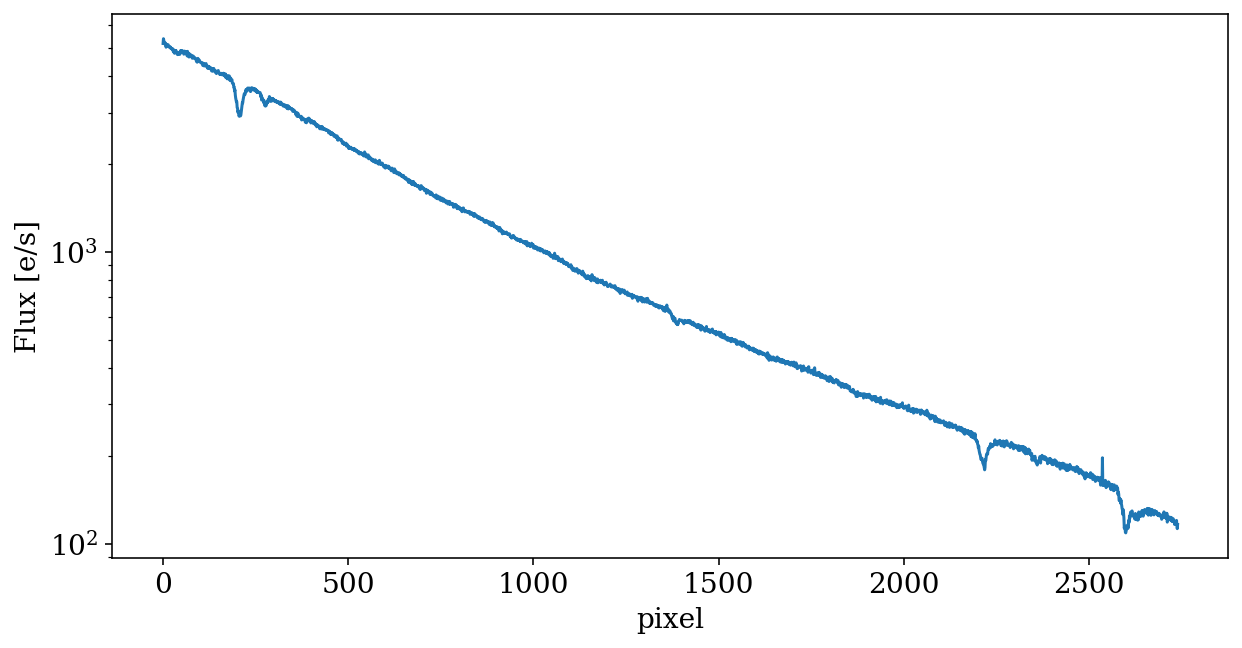

In [140]:
# extract the spectrum
spc1d_std = np.sum(std_star_clean[150:300,:2740], axis=0)
#spc1d_err
plt.plot(spc1d_std)
plt.yscale('log')
plt.xlabel('pixel')
plt.ylabel('Flux [e/s]')

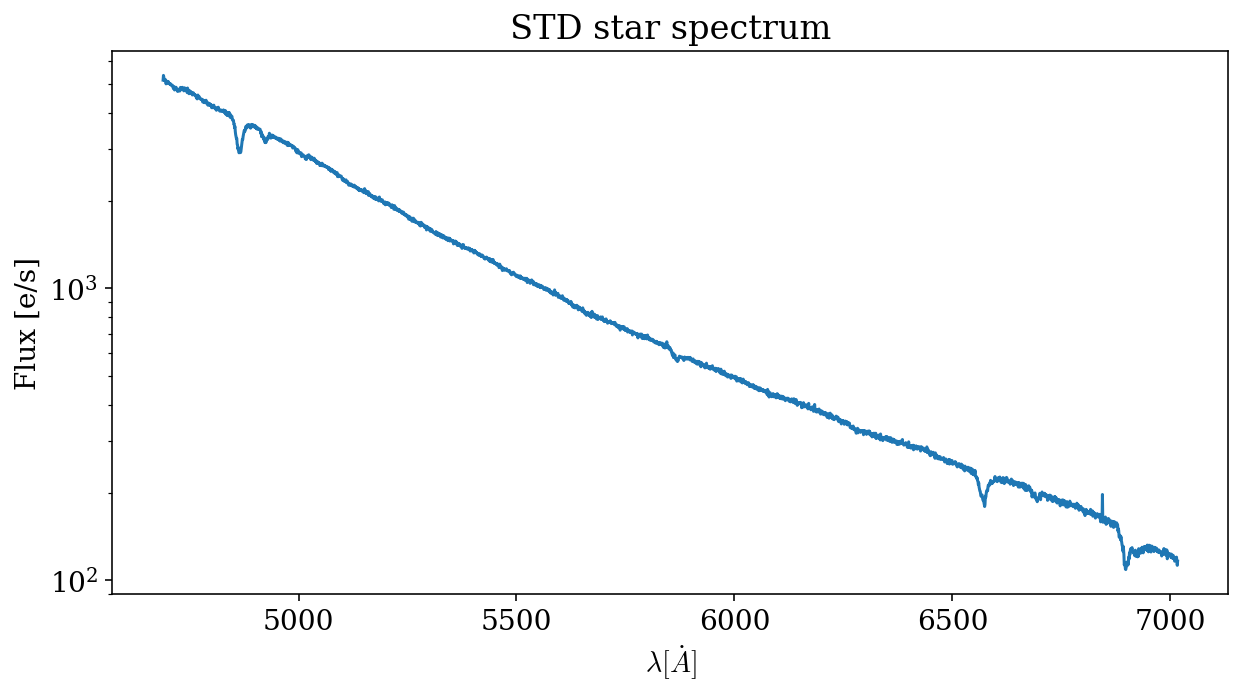

In [168]:
# convert to wavelengths:
plt.plot(wave, spc1d_std)
plt.yscale('log')
plt.xlabel('$\lambda [\dot{A}]$')
plt.ylabel('Flux [e/s]')
plt.title('STD star spectrum')
plt.show()

In [142]:
wave.shape

(2740,)

In [143]:
def flux_nu(m): 
    return 10**(-m/2.5) * 3631 #Jy
    

def flux_lambda (m):
    return flux_nu(m) / (3.34*10**4) / (5008)**2

def electron_rate_ADU(m):
    C_Ha = 15.39
    C_OII = 15.28
    C_SII = 15.47
    
    return flux_lambda(m) * 10**C_Ha  / (0.6)

Text(0, 0.5, 'magnitude')

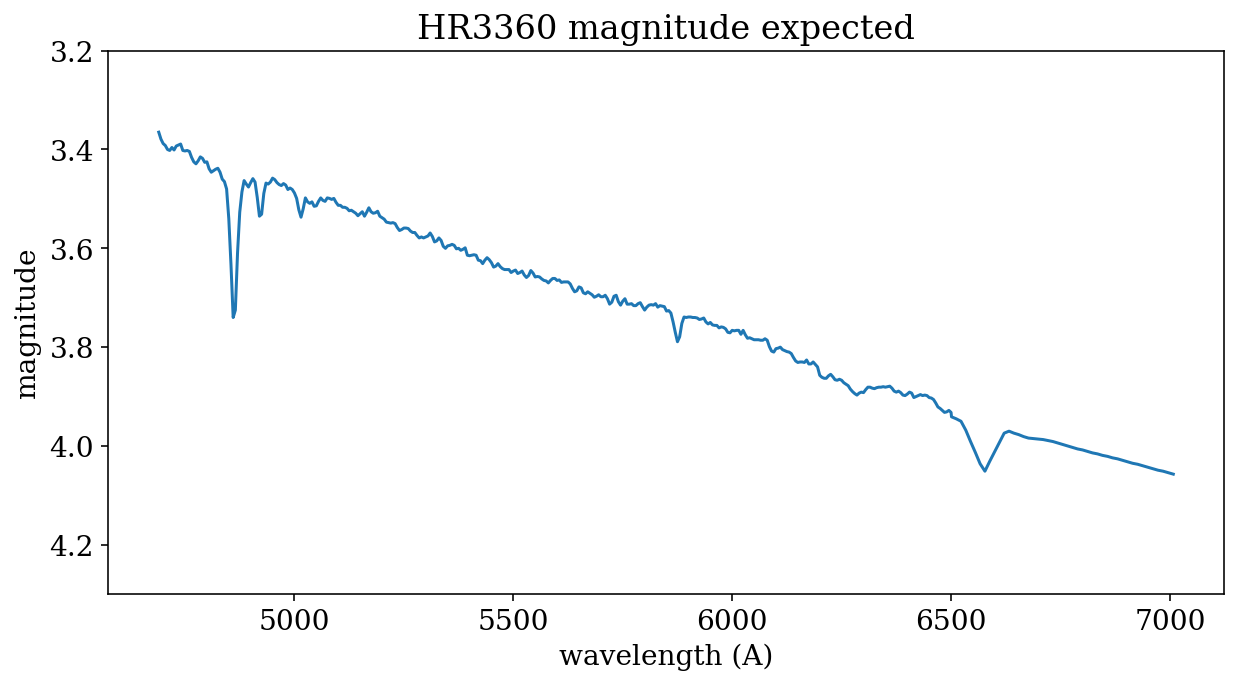

In [144]:
# read data of the real expected flux:
real_std_wv, real_std_magnitude = np.loadtxt('HD3360_flux.txt', unpack=True)

cut_realspct_wv = real_std_wv[(real_std_wv>=int(wave.min()))&
                           (real_std_wv<=int(wave.max()))]

cut_realspct_mag = real_std_magnitude[(real_std_wv>=int(wave.min()))&
                                      (real_std_wv<=int(wave.max()))]

plt.ylim(4.3,3.2)
plt.plot(cut_realspct_wv, cut_realspct_mag)
plt.title('HR3360 magnitude expected')
plt.xlabel('wavelength (A)')
plt.ylabel('magnitude')

In [151]:
from scipy.interpolate import interp1d

Text(0, 0.5, 'flux(erg/s/cm^2/A)')

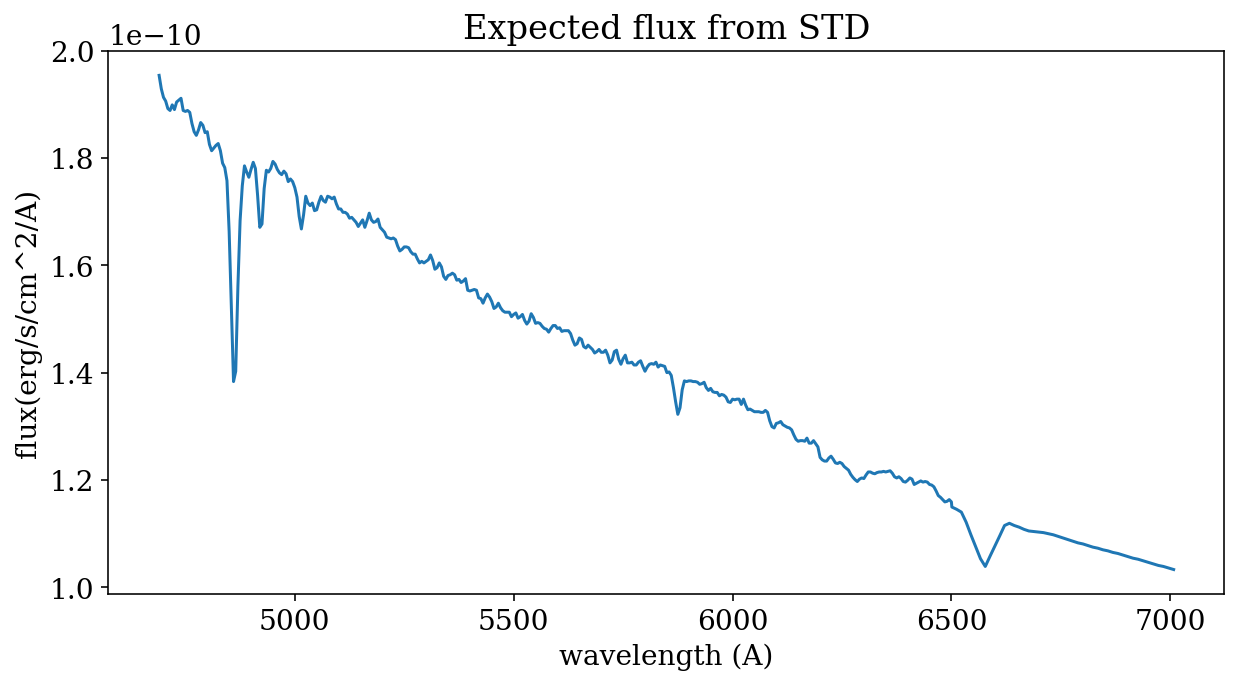

In [152]:
#converting from magnitude to flux:
cut_spct_flux = flux_lambda(cut_realspct_mag)
plt.plot(cut_realspct_wv, cut_spct_flux)
plt.title('Expected flux from STD')
plt.xlabel('wavelength (A)')
plt.ylabel('flux(erg/s/cm^2/A)')

Our data are bigger than the tabulated one, so we interpolate them.

In [153]:
# total tabulated flux:
tot_tab_flux = flux_lambda(real_std_magnitude)
cut_tab_flux = tot_tab_flux[(real_std_wv>2000) & (real_std_wv<10000)]
cut_tab_wv = real_std_wv[(real_std_wv>2000) & (real_std_wv<10000)]

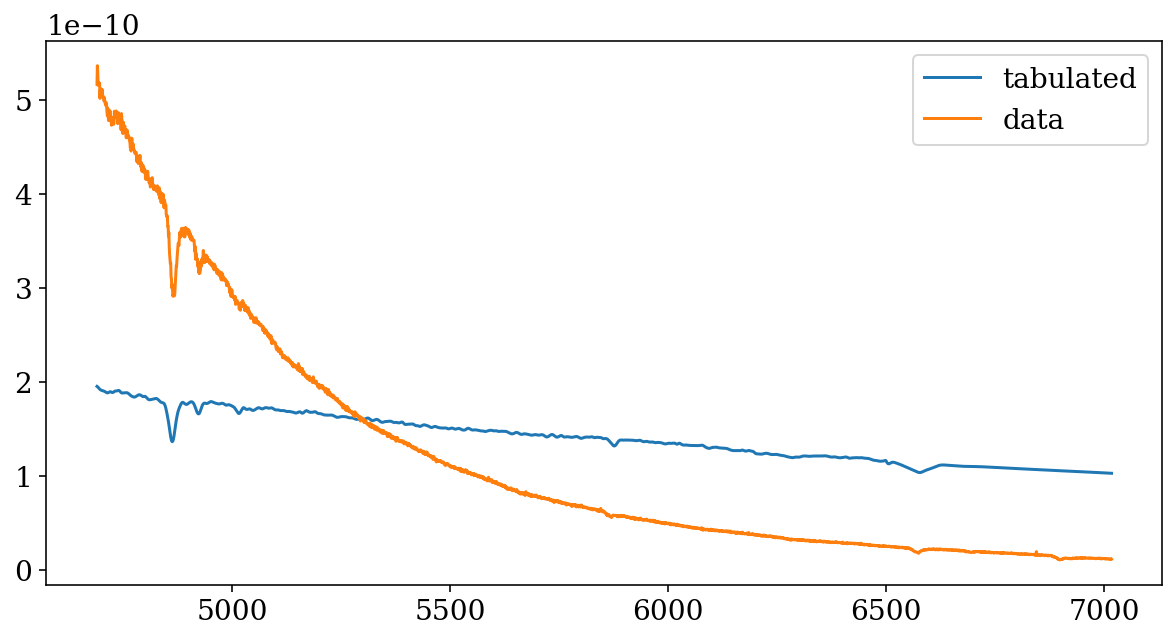

In [174]:
interp_spct_tab = interp1d(cut_tab_wv, cut_tab_flux, kind='cubic')
interp_tab_flux = interp_spct_tab(wave)
plt.plot(wave, interp_tab_flux, label='tabulated')
plt.plot(wave, spc1d_std/1e13, label='data')
plt.legend()

In [155]:
interp_tab_flux.shape

(2740,)

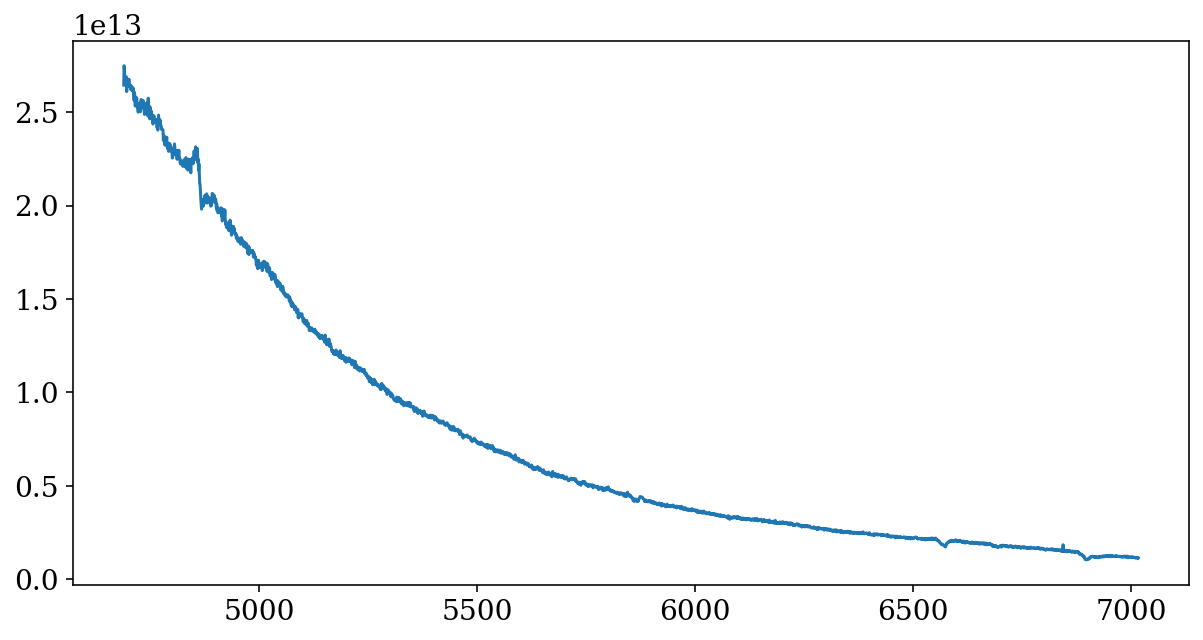

In [175]:
spct_ratio = spc1d_std / interp_tab_flux
plt.plot(wave, spct_ratio)
#plt.yscale('log')

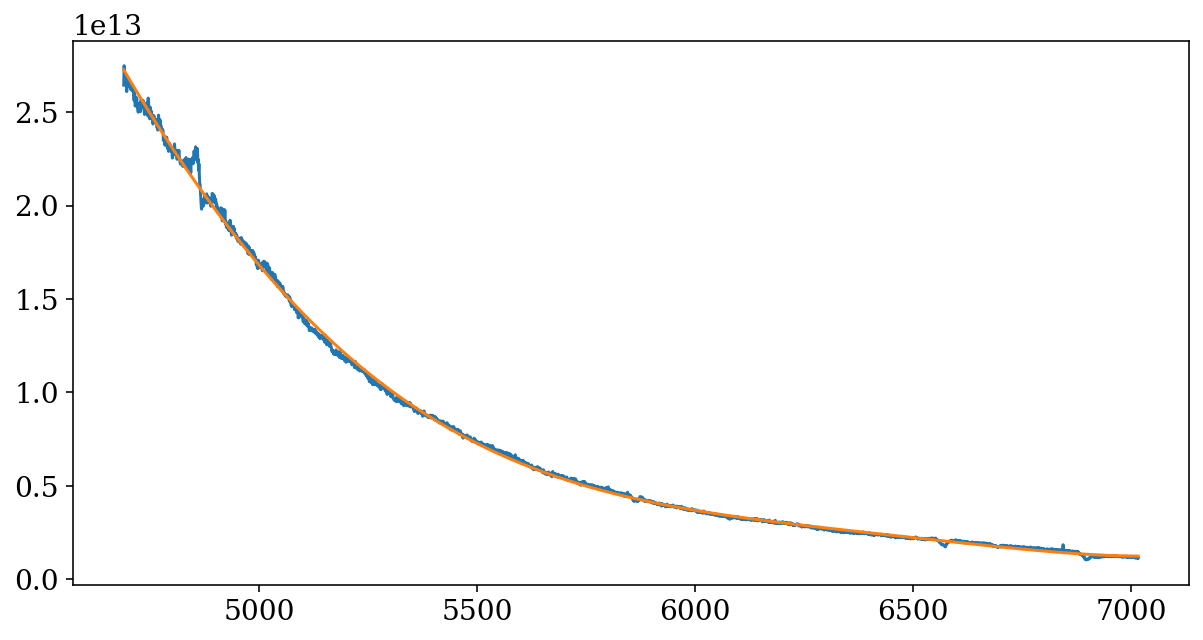

In [235]:
polinomial_fit = np.polyfit(wave, spct_ratio, 5)
fit_ratio = np.poly1d(polinomial_fit)

response_funct = fit_ratio(wave)

plt.plot(wave, spct_ratio)
plt.plot(wave,response_funct)

## spectroscopy on our stars

['../work/20230110\\NGC956-300-001.fit', '../work/20230110\\NGC956_1-300-001.fit']


Text(0.5, 1.0, '../work/20230110\\NGC956-300-001.fit')

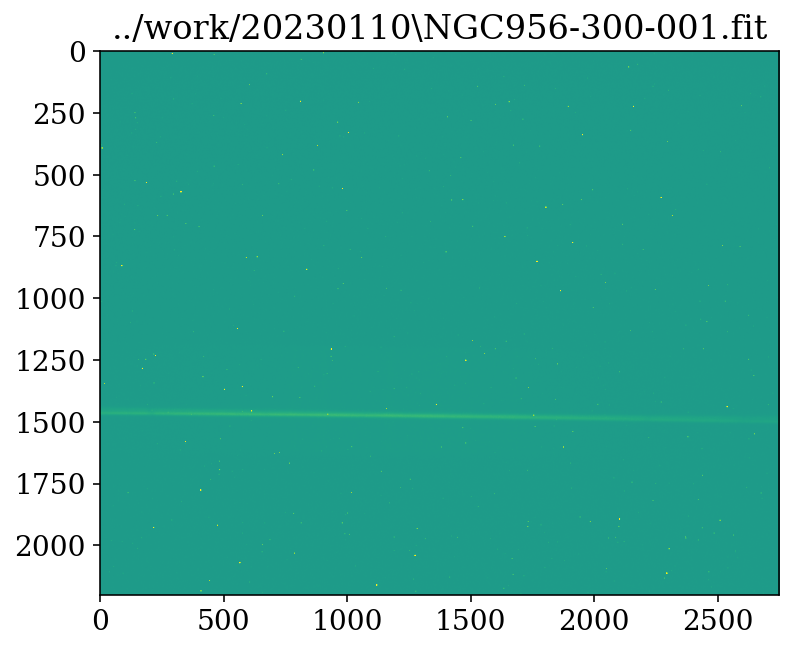

In [249]:
NGC956_name = glob.glob('../work/20230110/NGC956*-300-001.fit')
print(NGC956_name)
NGC956 = read_files(NGC956_name)
NGC956_1 = NGC956[0]
plt.imshow(NGC956_1, clim=(0,2500))
plt.title(str(NGC956_name[0]))

Text(0.5, 1.0, '../work/20230110\\NGC956_1-300-001.fit')

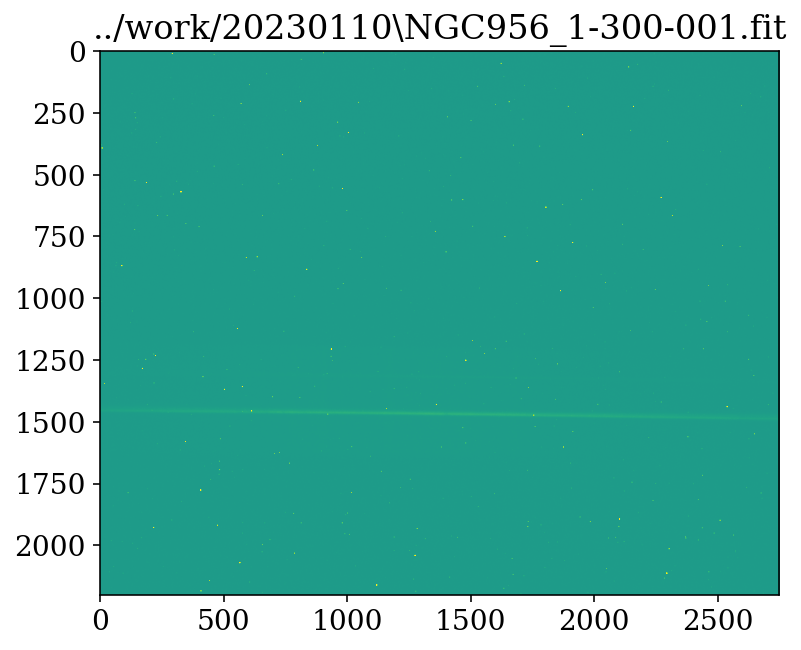

In [250]:
NGC956_2 = NGC956[1]
plt.imshow(NGC956_2, clim=(0,2500))
plt.title(str(NGC956_name[1]))

Text(0.5, 1.0, 'NGC956_1 trace')

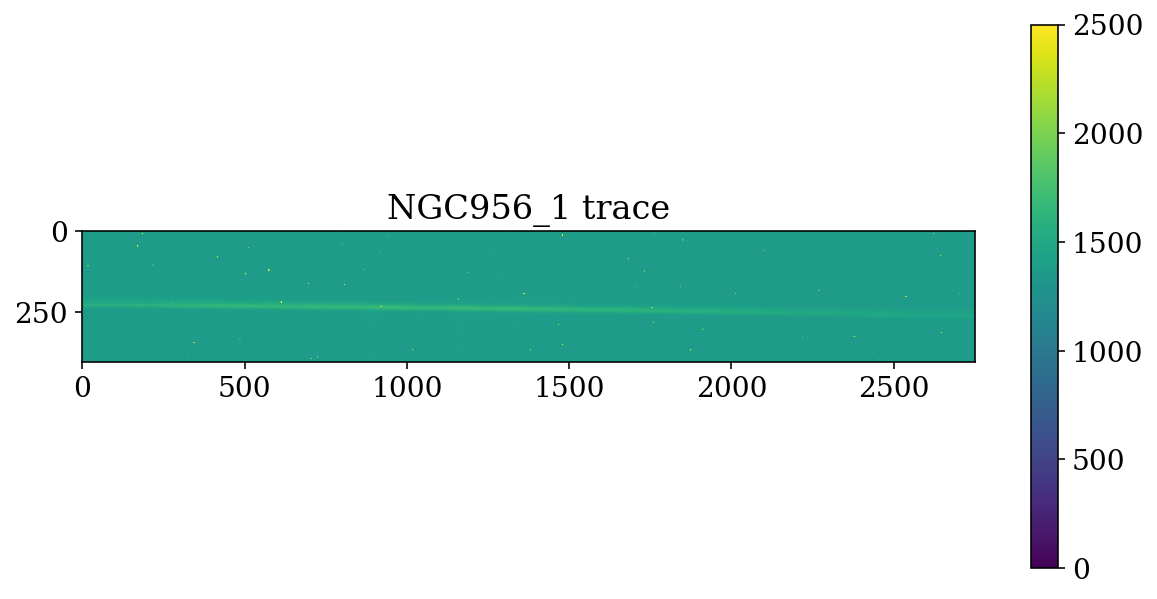

In [253]:
#define the trace
NGC956_1trace = NGC956_1[trace_mask]
NGC956_2trace = NGC956_2[trace_mask]
plt.imshow(NGC956_1trace, clim=(0,2500))
plt.colorbar()
plt.title('NGC956_1 trace')

Text(0.5, 1.0, 'NGC956_2 trace')

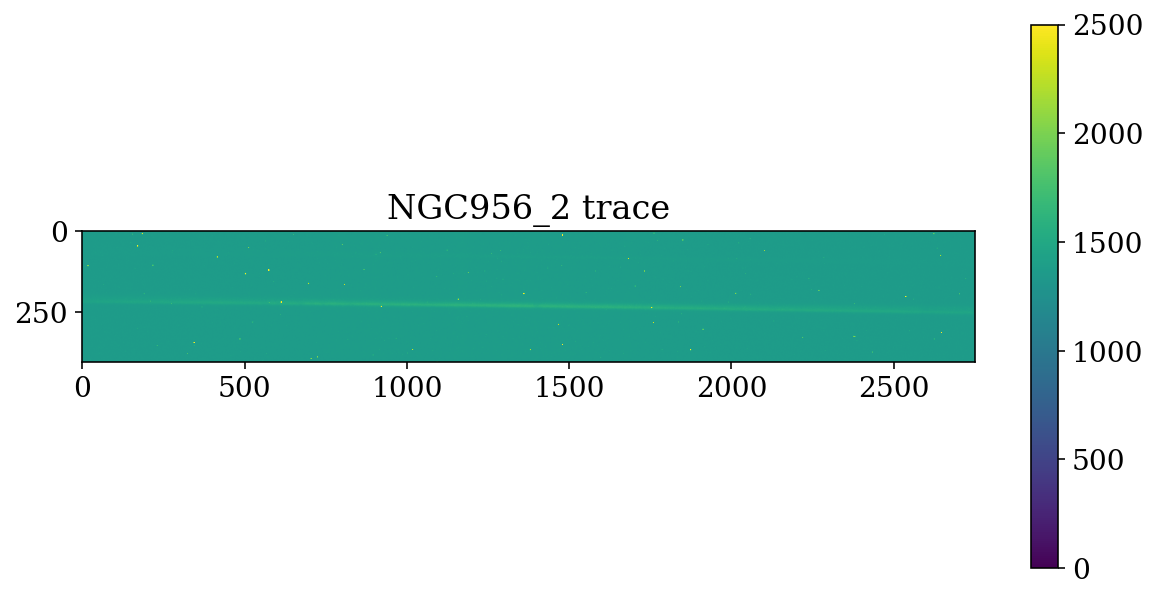

In [254]:
plt.imshow(NGC956_2trace, clim=(0,2500))
plt.colorbar()
plt.title('NGC956_2 trace')

<ipython-input-24-869aaf23c345>:4: RuntimeWarning: divide by zero encountered in true_divide
  data_normflat = data_nb / norm_flat


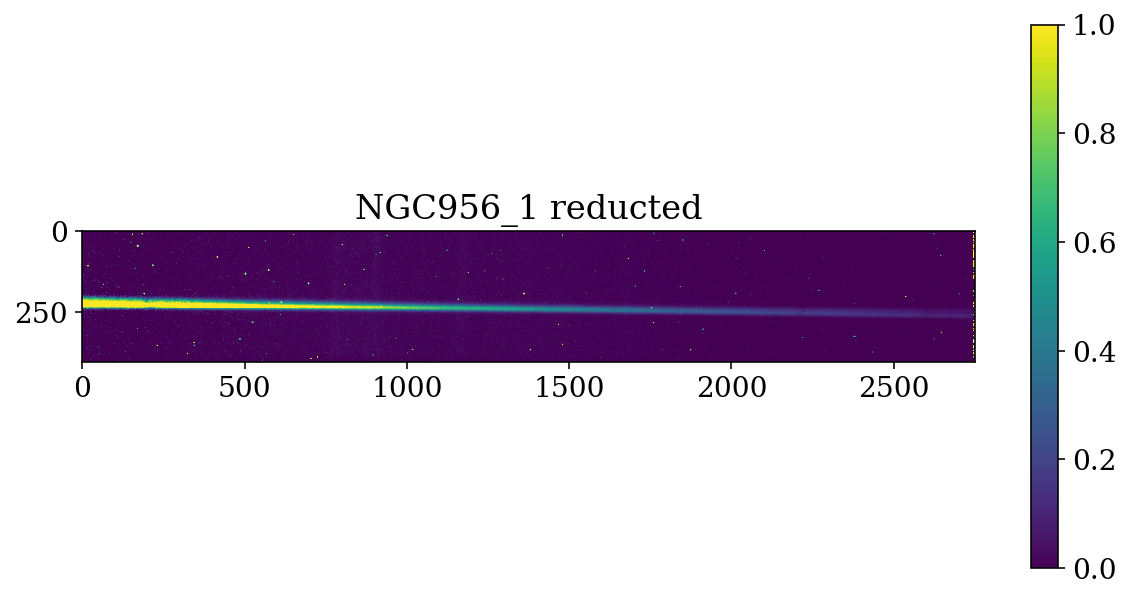

In [256]:
#data reduction
NGC956_1red = data_reduction(NGC956_1trace, 300)
NGC956_2red = data_reduction(NGC956_2trace, 300)

plt.imshow(NGC956_1red, clim=(0,1))
plt.title('NGC956_1 reducted')
plt.colorbar()

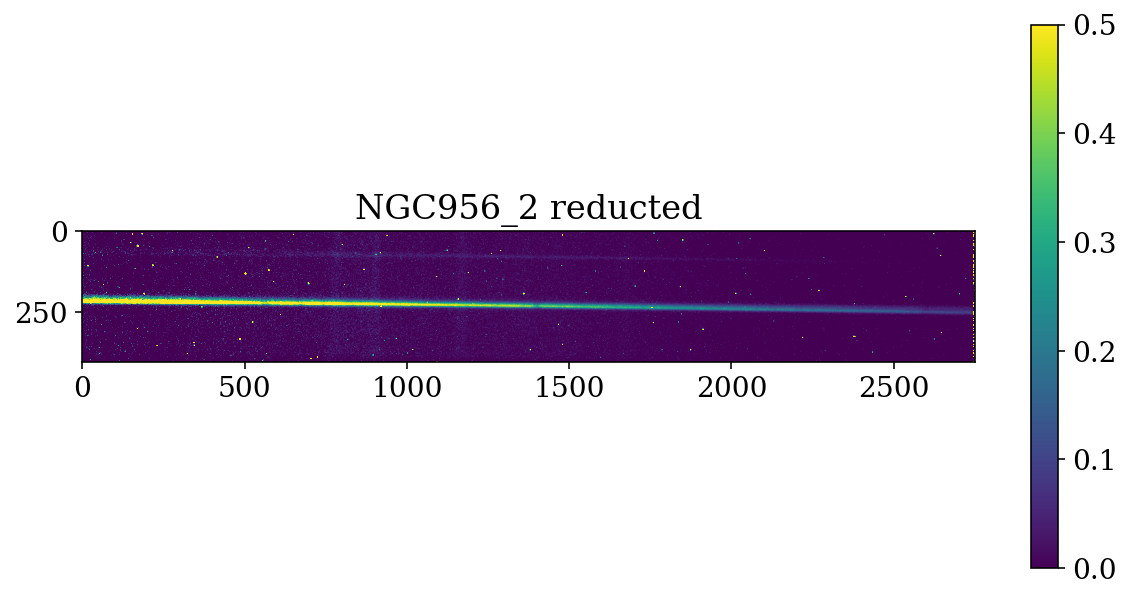

In [258]:
plt.imshow(NGC956_2red, clim=(0,0.5))
plt.title('NGC956_2 reducted')
plt.colorbar()

In [260]:
skymodNGC1_1 = np.median(NGC956_1red[0:100,:])
skymodNGC2_1 = np.median(NGC956_1red[NGC956_1red.shape[0]-100,:])

print(skymodNGC1_1, skymodNGC2_1)
skymodNGC_1 = (skymodNGC1_1+skymodNGC2_1)/2

print('mean sky = ', skymodNGC_1)

-0.0026205386878515773 -0.0011956553262504428
mean sky =  -0.00190809700705101


In [261]:
skymodNGC1_2 = np.median(NGC956_2red[0:100,:])
skymodNGC2_2 = np.median(NGC956_2red[NGC956_2red.shape[0]-100,:])

print(skymodNGC1_2, skymodNGC2_2)
skymodNGC_2 = (skymodNGC1_2+skymodNGC2_2)/2

print('mean sky = ', skymodNGC_2)

-0.0011000483775728605 -0.0006781751644677327
mean sky =  -0.0008891117710202966


In [263]:
#construct sky model in 2D:
print(NGC956_1red.shape)

#1st star
nx,ny = NGC956_1red.shape
sky2dNGC_1 = np.transpose(np.tile(skymodNGC_1, (ny,404))) 
print(sky2dNGC_1.shape)

#2nd star
nx,ny = NGC956_2red.shape
sky2dNGC_2 = np.transpose(np.tile(skymodNGC_2, (ny,404))) 
print(sky2dNGC_2.shape)

(404, 2750)
(404, 2750)
(404, 2750)


Text(0.5, 1.0, 'NGC956_1 clean')

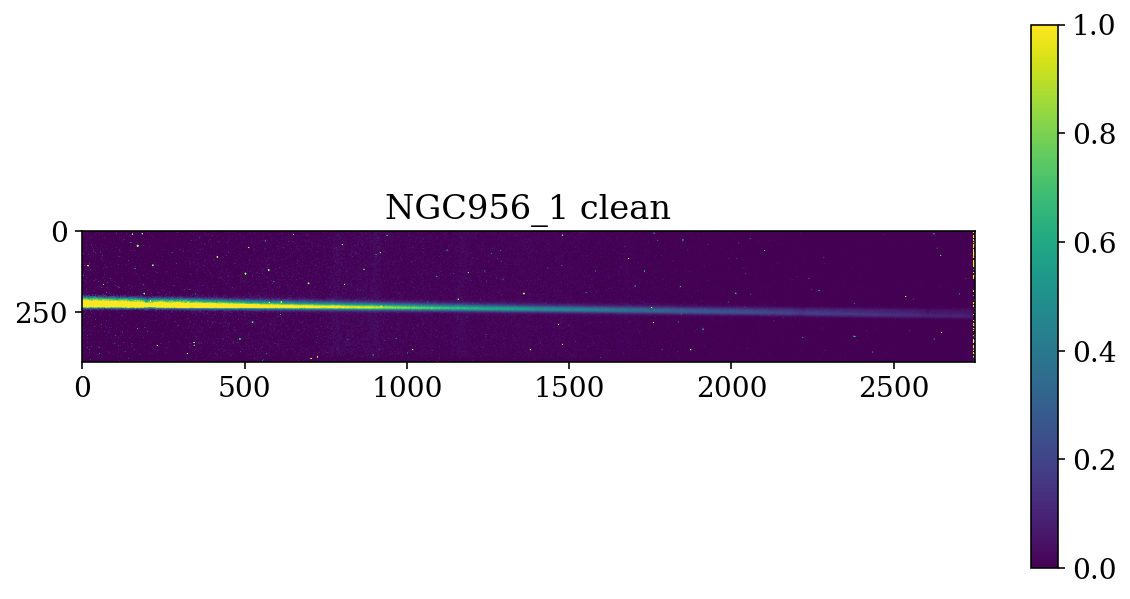

In [265]:
#subtract the mean sky:
#1st star
NGC956_1clean = NGC956_1red - sky2dNGC_1

#2nd star
NGC956_2clean = NGC956_2red - sky2dNGC_2

plt.imshow(NGC956_1clean, clim=(0,1))
plt.colorbar()
plt.title('NGC956_1 clean')

Text(0.5, 1.0, 'NGC956_2 clean')

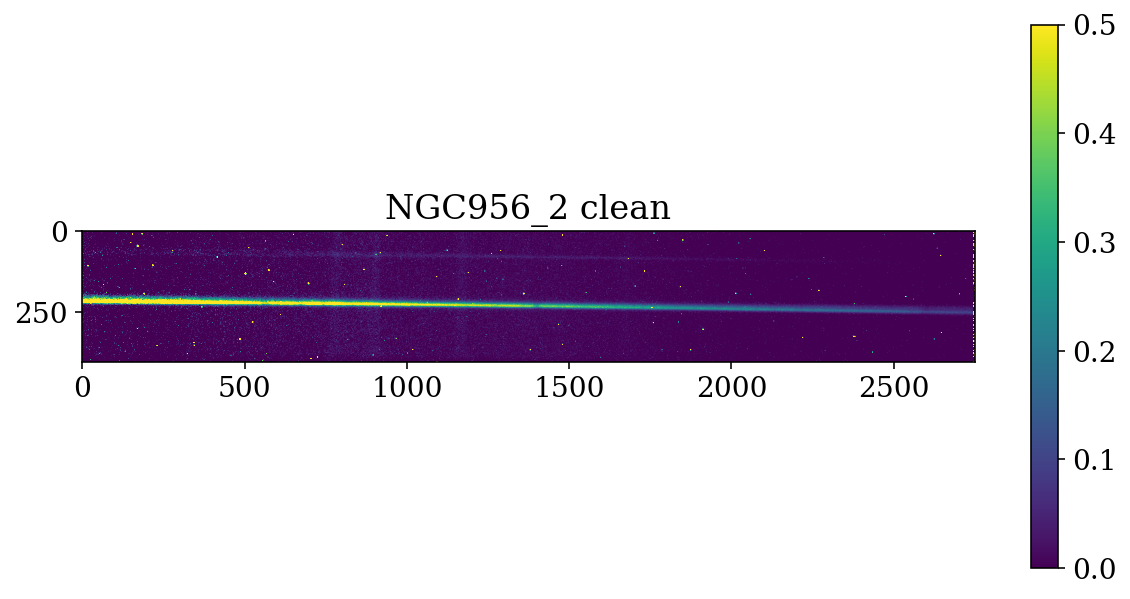

In [267]:
plt.imshow(NGC956_2clean, clim=(0,0.5))
plt.colorbar()
plt.title('NGC956_2 clean')

In [225]:
#save file
hdu_NGC9561 = fits.PrimaryHDU(NGC956_1clean)
hdul_NGC9561 = fits.HDUList([hdu_NGC9561])
hdul_NGC9561.writeto('NGC956_1.fits', overwrite=True)

In [268]:
hdu_NGC9562 = fits.PrimaryHDU(NGC956_2clean)
hdul_NGC9562 = fits.HDUList([hdu_NGC9562])
hdul_NGC9562.writeto('NGC956_2.fits', overwrite=True)

Text(0.5, 1.0, 'Extracted spectrum NGC956_1')

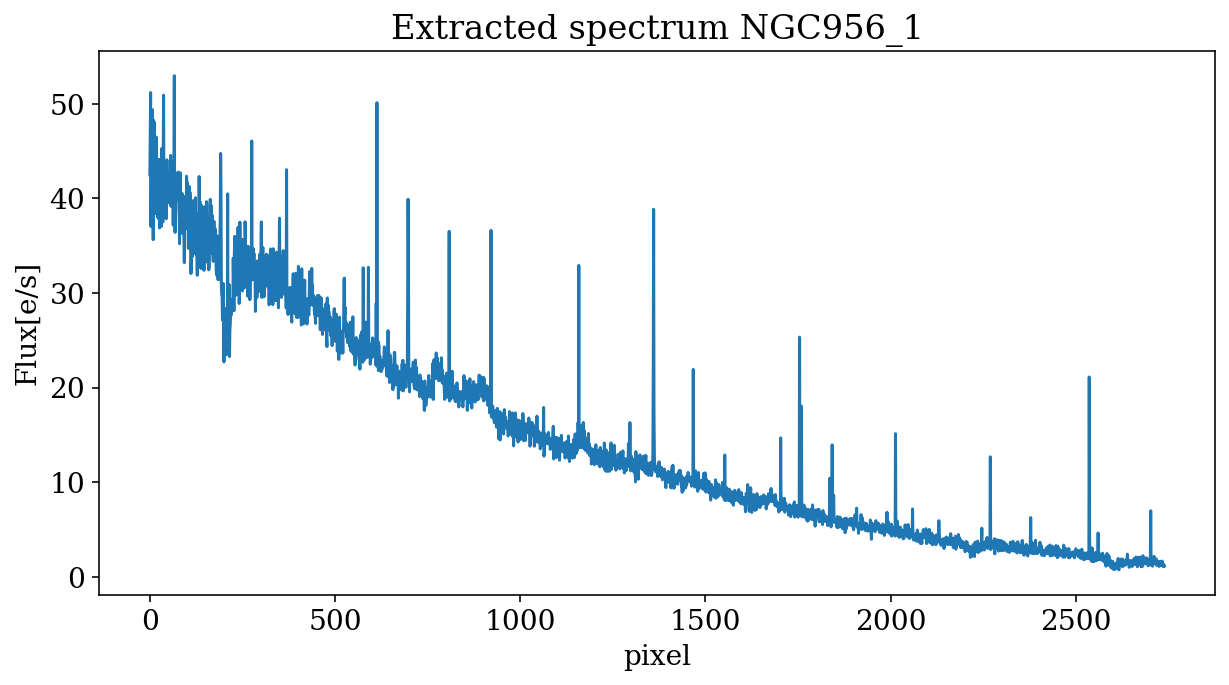

In [270]:
#extract the spectrum 
#1st star
spct1d_NGC956_1 = np.sum(NGC956_1clean[150:300,:2740], axis=0)

plt.plot(spct1d_NGC956_1)
#plt.yscale('log')
plt.xlabel('pixel')
plt.ylabel('Flux[e/s]')
plt.title('Extracted spectrum NGC956_1')

Text(0.5, 1.0, 'Extracted spectrum NGC956_2')

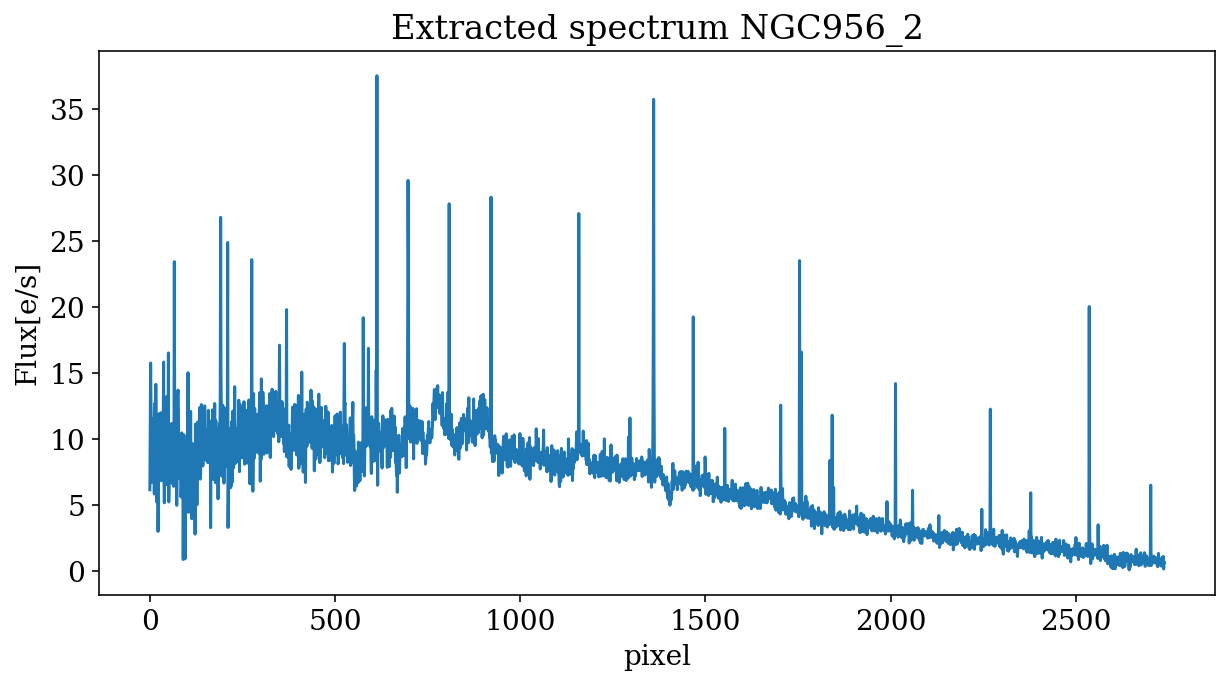

In [271]:
#extract the spectrum 
#2nd star
spct1d_NGC956_2 = np.sum(NGC956_2clean[150:300,:2740], axis=0)

plt.plot(spct1d_NGC956_2)
#plt.yscale('log')
plt.xlabel('pixel')
plt.ylabel('Flux[e/s]')
plt.title('Extracted spectrum NGC956_2')

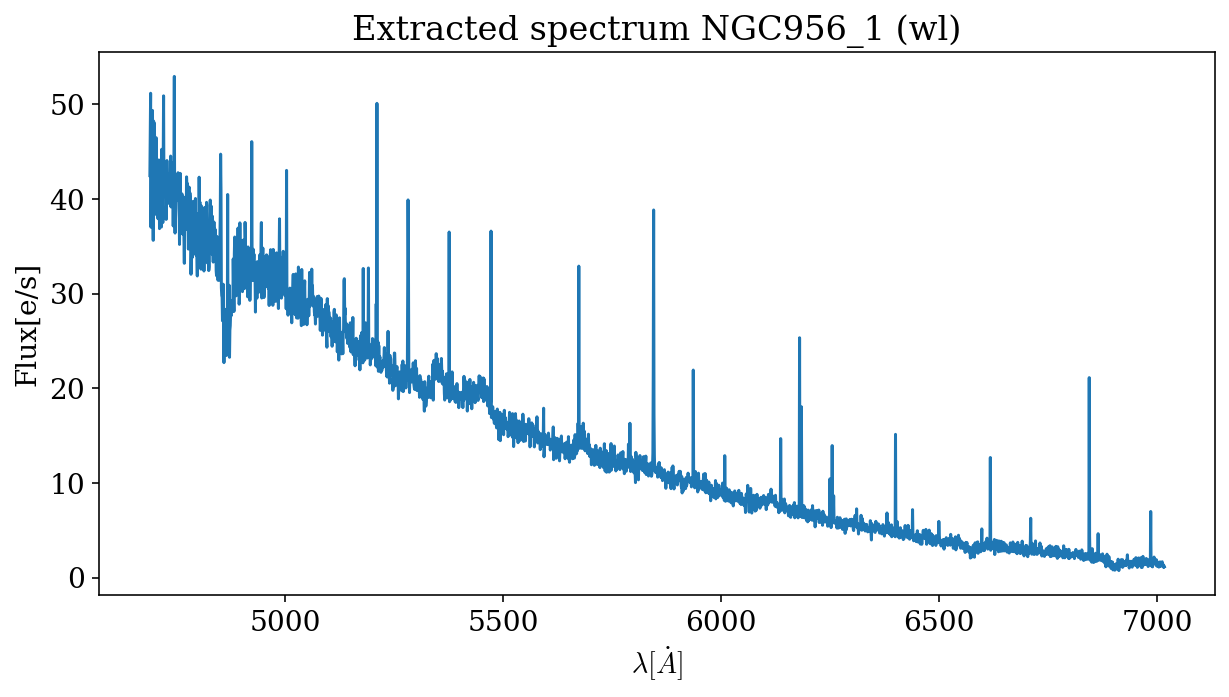

In [273]:
#convertion in wl:
#1st star
plt.plot(wave, spct1d_NGC956_1)
#plt.title('NGC956 star spectrum')
plt.ylabel('Flux[e/s]')
plt.xlabel('$\lambda[\dot{A}]$')
plt.title('Extracted spectrum NGC956_1 (wl)')
plt.show()

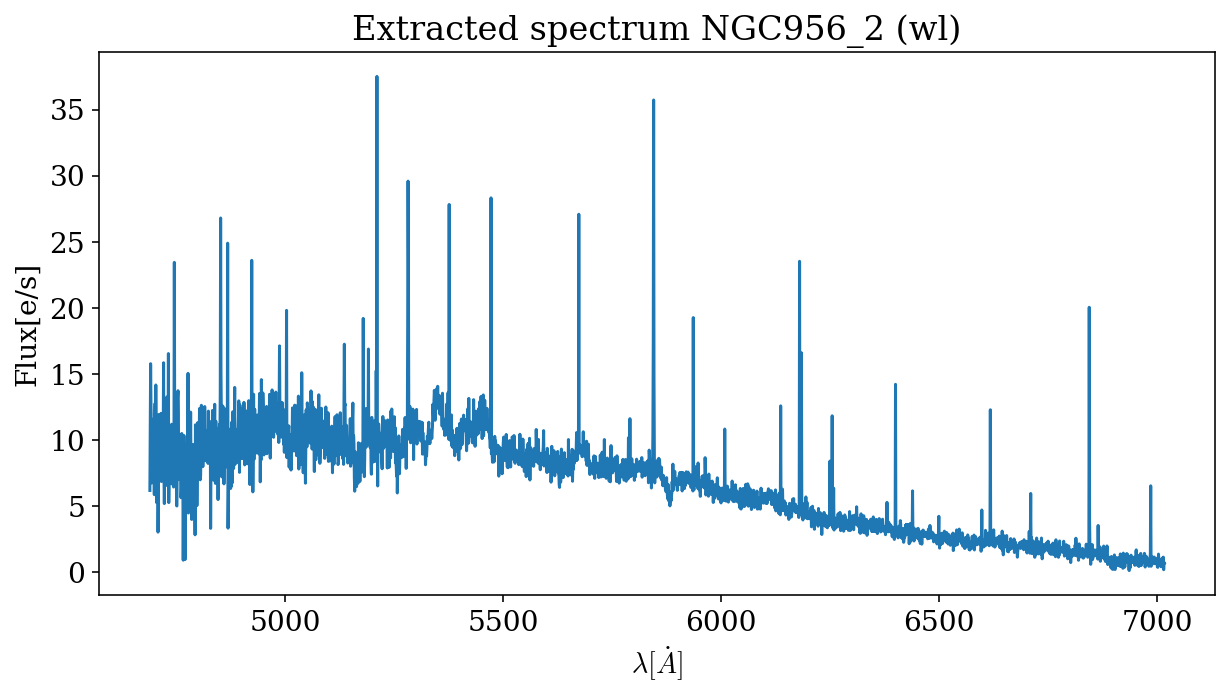

In [274]:
#convertion in wl:
#2nd star
plt.plot(wave, spct1d_NGC956_2)
#plt.title('NGC956 star spectrum')
plt.ylabel('Flux[e/s]')
plt.xlabel('$\lambda[\dot{A}]$')
plt.title('Extracted spectrum NGC956_2 (wl)')
plt.show()

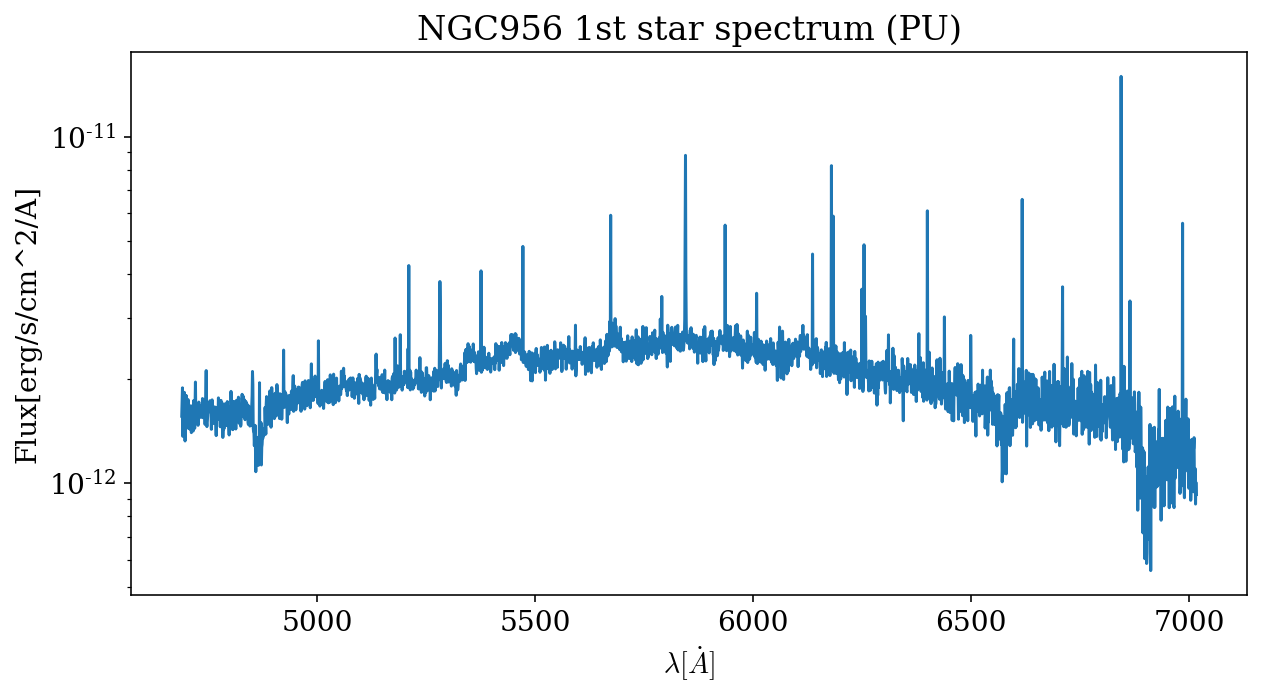

In [277]:
#conversion in physical units:
#1st star
spct1d_NGC956_1PU = spct1d_NGC956_1 / response_funct
plt.plot(wave,spct1d_NGC956_1PU)
plt.title('NGC956 1st star spectrum (PU)')
plt.ylabel('Flux[erg/s/cm^2/A]')
plt.xlabel('$\lambda[\dot{A}]$')
plt.yscale('log')
plt.show()

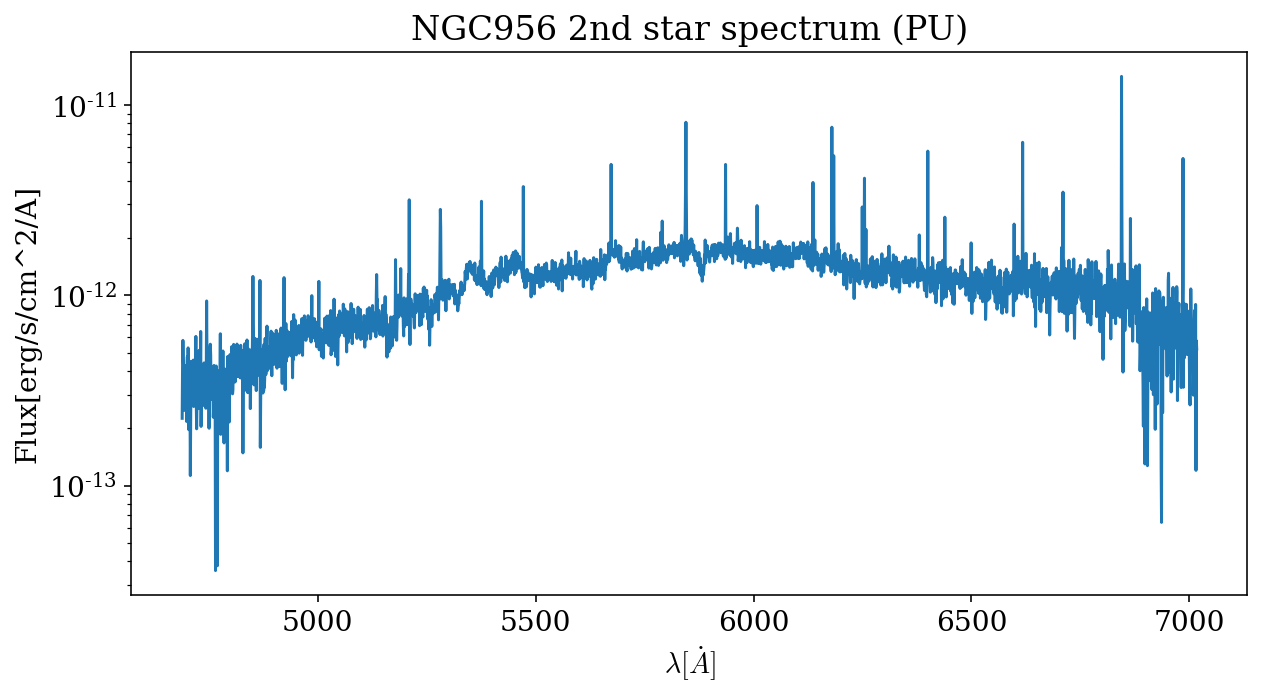

In [276]:
#conversion in physical units:
#2nd star
spct1d_NGC956_2PU = spct1d_NGC956_2 / response_funct
plt.plot(wave,spct1d_NGC956_2PU)
plt.title('NGC956 2nd star spectrum (PU)')
plt.ylabel('Flux[erg/s/cm^2/A]')
plt.xlabel('$\lambda[\dot{A}]$')
plt.yscale('log')
plt.show()

# Wrong Stuff

Text(0, 0.5, 'magnitude')

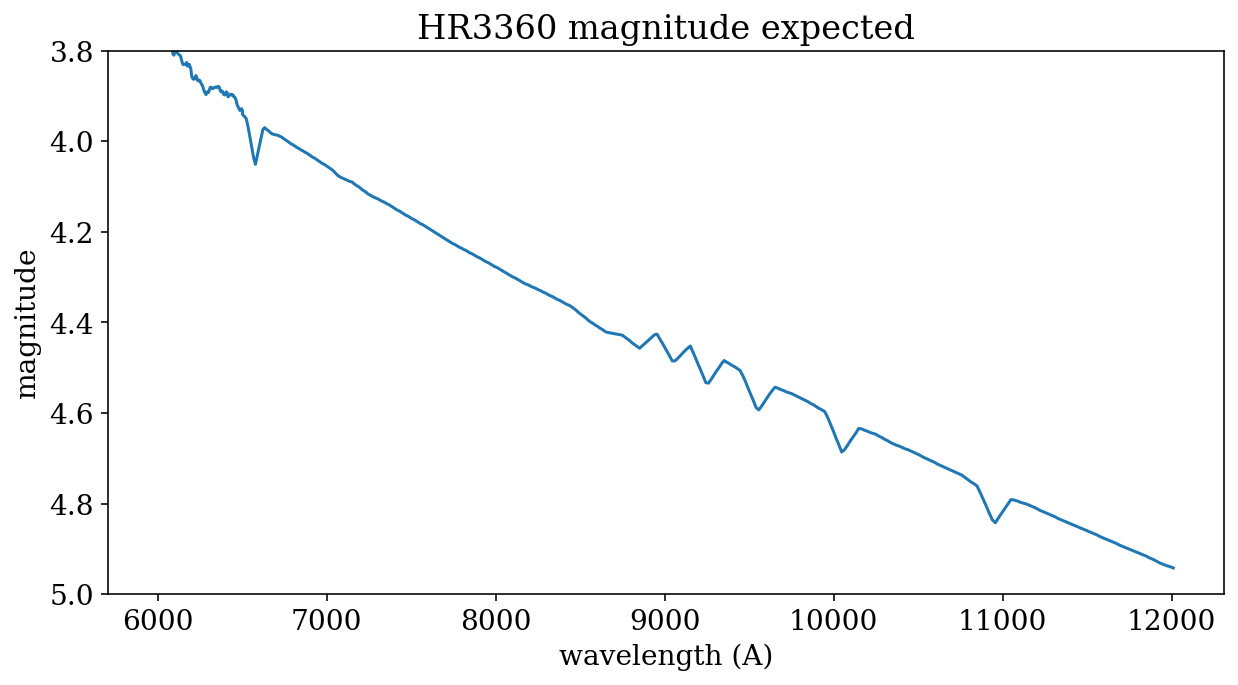

In [51]:
# read data of the real expected flux:
real_std_wv, real_std_magnitude = np.loadtxt('HD3360_flux.txt', unpack=True)

plt.ylim(5,3.8)
plt.plot(real_std_wv[real_std_wv>6000], real_std_magnitude[real_std_wv>6000])
plt.title('HR3360 magnitude expected')
plt.xlabel('wavelength (A)')
plt.ylabel('magnitude')

In [52]:
def flux_nu(m): 
    return 10**(-m/2.5) * 3631 #Jy
    

def flux_lambda (m):
    return flux_nu(m) / (3.34*10**4) / (5008)**2

def electron_rate_ADU(m):
    C_Ha = 15.39
    C_OII = 15.28
    C_SII = 15.47
    
    return flux_lambda(m) * 10**C_Ha  / (0.6)

Text(0, 0.5, 'flux(erg/s/cm^2/A)')

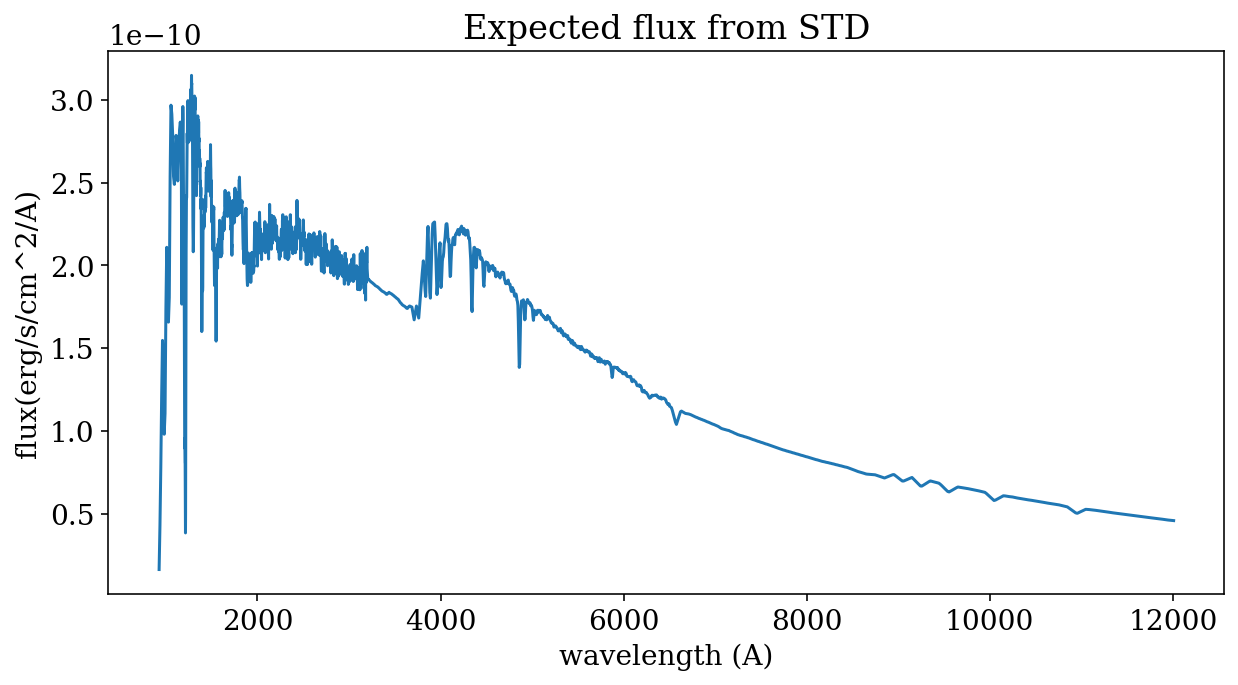

In [53]:
#converting from magnitude to flux:
real_fluxl_std = flux_lambda(real_std_magnitude)
plt.plot(real_std_wv, real_fluxl_std)
plt.title('Expected flux from STD')
plt.xlabel('wavelength (A)')
plt.ylabel('flux(erg/s/cm^2/A)')

## Wavelength calibration

Text(0, 0.5, 'Flux (erg/s/cm^2)')

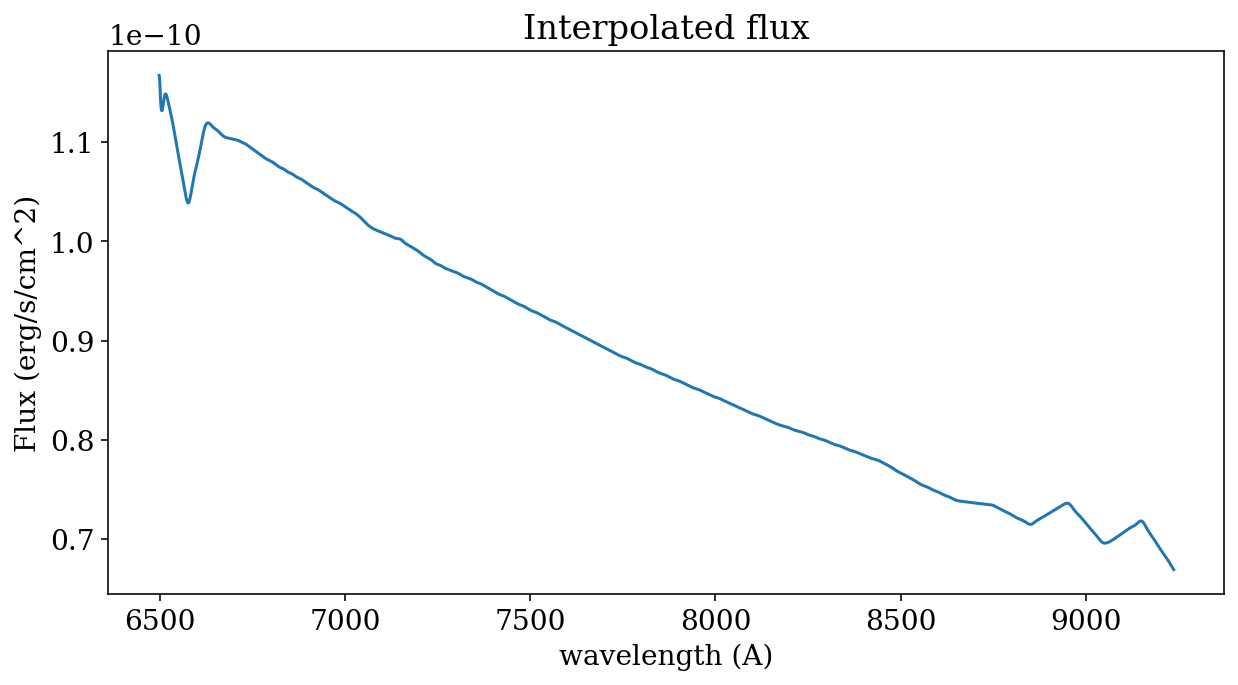

In [54]:
#interpolate:
from scipy.interpolate import interp1d

wl_range = np.arange(6498,9238)

real_std_wv_cut = real_std_wv[(real_std_wv>2000) & (real_std_wv<10000)]
real_std_flux_cut = real_fluxl_std[(real_std_wv>2000) & (real_std_wv<10000)]

interp_flux = interp1d(real_std_wv_cut, real_std_flux_cut, kind='cubic')

plt.plot(wl_range, interp_flux(wl_range))
plt.title('Interpolated flux')
plt.xlabel('wavelength (A)')
plt.ylabel('Flux (erg/s/cm^2)')

Text(0, 0.5, 'Flux [e/s]')

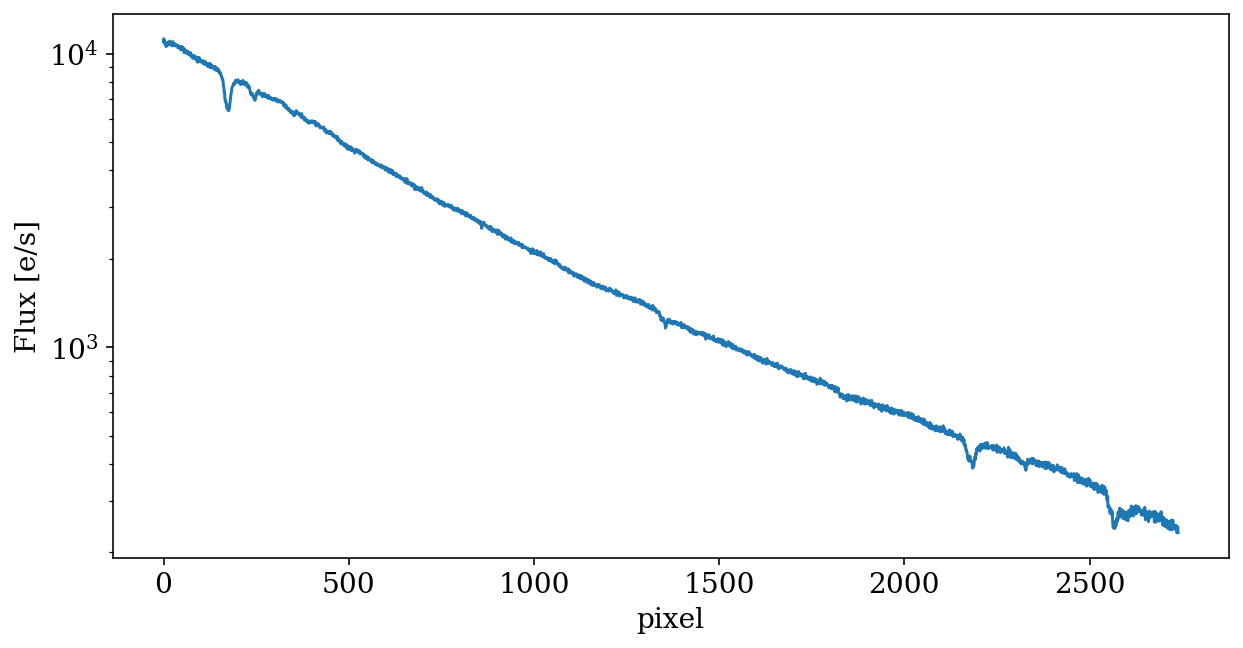

In [55]:
spc1d = np.sum(std_star_clean[100:300,:2740], axis=0)
#spc1d_err
plt.plot(spc1d)
plt.yscale('log')
plt.xlabel('pixel')
plt.ylabel('Flux [e/s]')

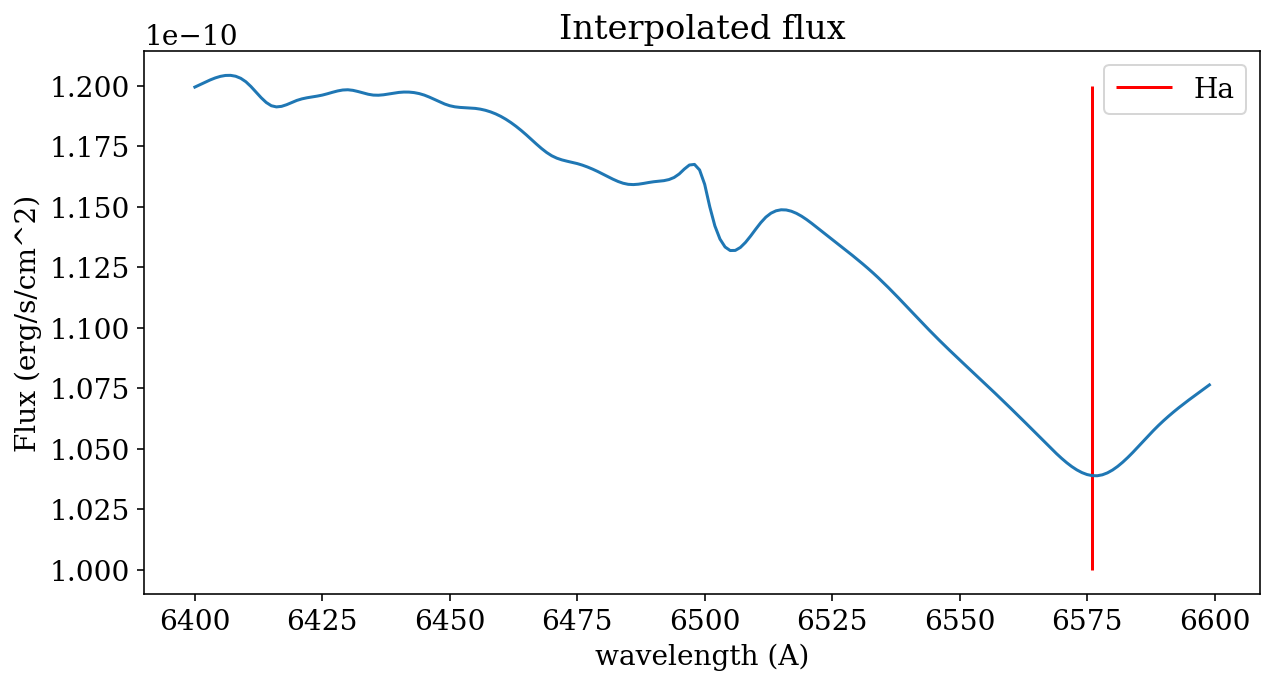

In [56]:
plt.plot(np.arange(6400,6600), interp_flux(np.arange(6400,6600)))
plt.title('Interpolated flux')
plt.xlabel('wavelength (A)')
plt.ylabel('Flux (erg/s/cm^2)')
plt.vlines(6576, 1e-10, 1.2e-10, label='Ha', colors='r')
plt.legend()

Comparing with the real spectra, we can recognize the $H\alpha$ absorption line at $6562.8 \dot{A}$

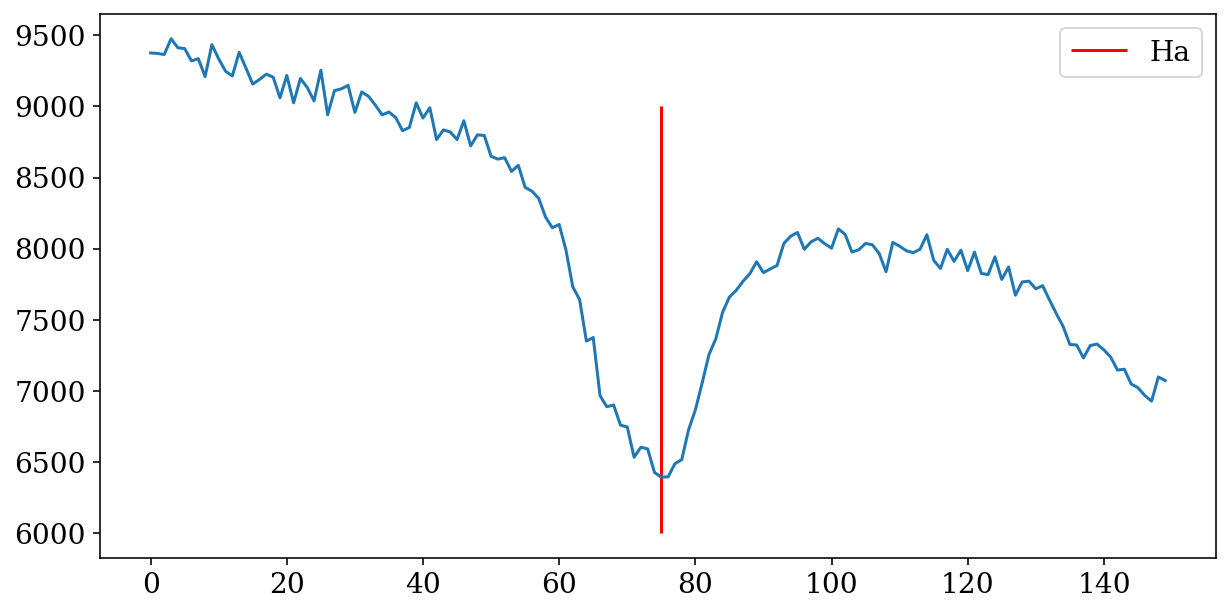

In [57]:
# identify the pixel corresponding to the wl:

plt.plot(spc1d[100:250])
plt.vlines(75, ymin=6000, ymax=9000, label='Ha', colors='r')
plt.legend()

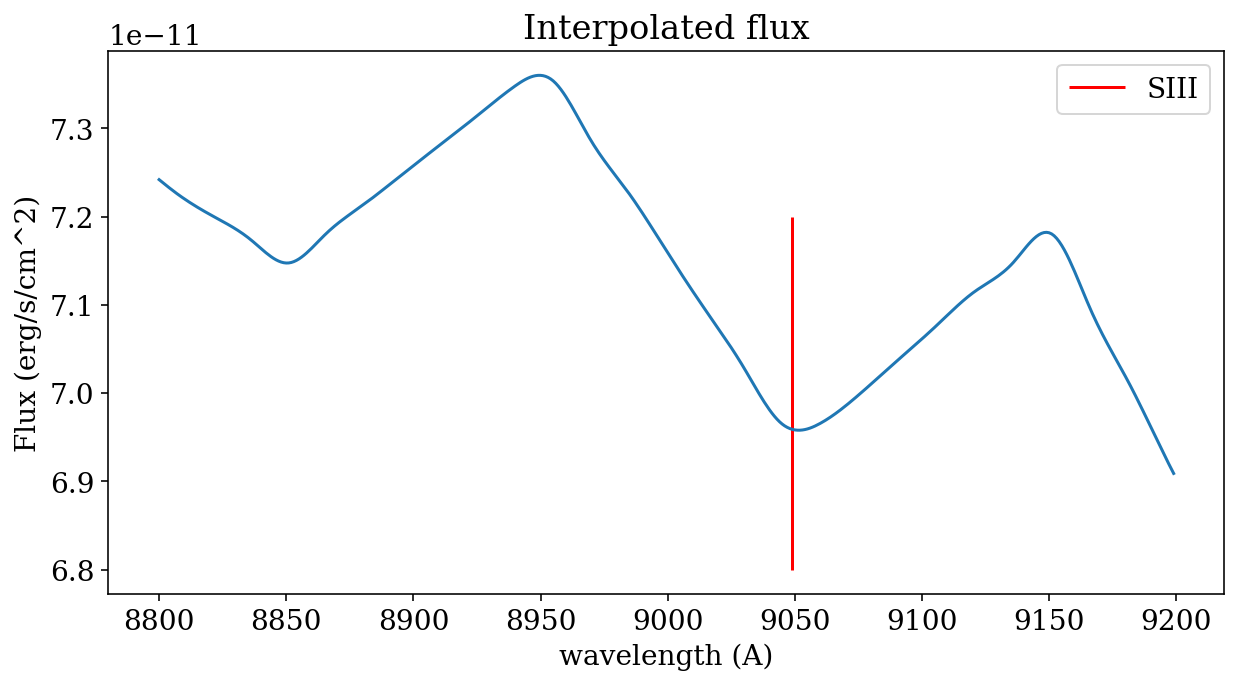

In [58]:
plt.plot(np.arange(8800,9200), interp_flux(np.arange(8800,9200)))
plt.title('Interpolated flux')
plt.xlabel('wavelength (A)')
plt.ylabel('Flux (erg/s/cm^2)')
plt.vlines(9049, 0.68e-10, 0.72e-10, label='SIII', colors='r')
plt.legend()

The absorption line $SIII$ is at $9068 \dot{A}$

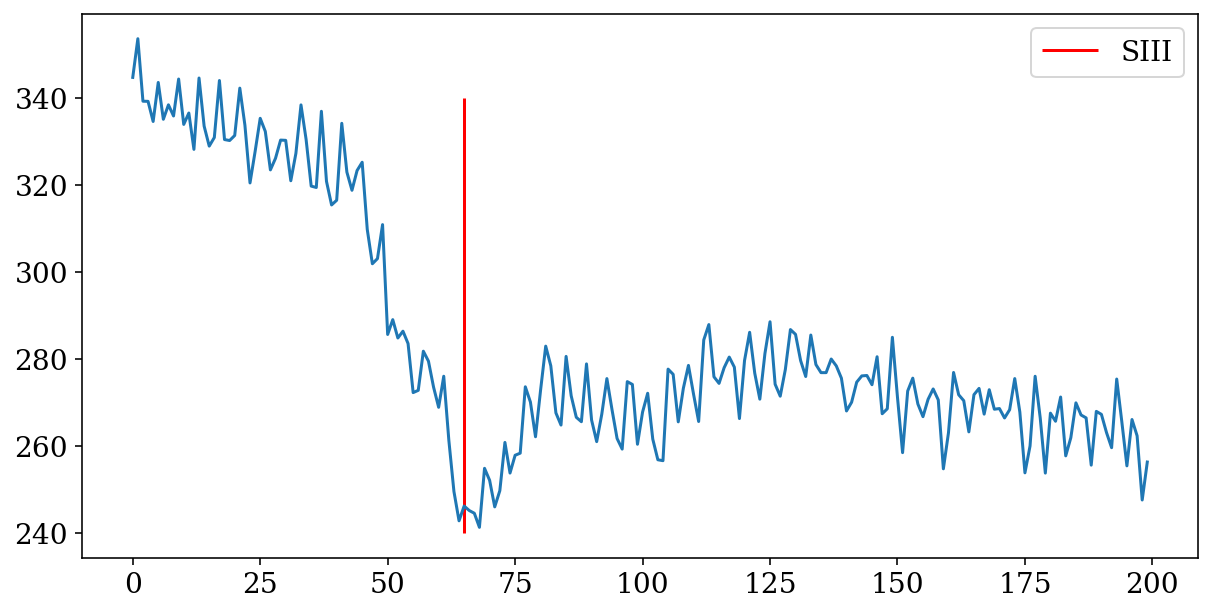

In [59]:
plt.plot(spc1d[2500:2700])
plt.vlines(65, ymin=240, ymax=340, label='SIII', colors='r')
plt.legend()

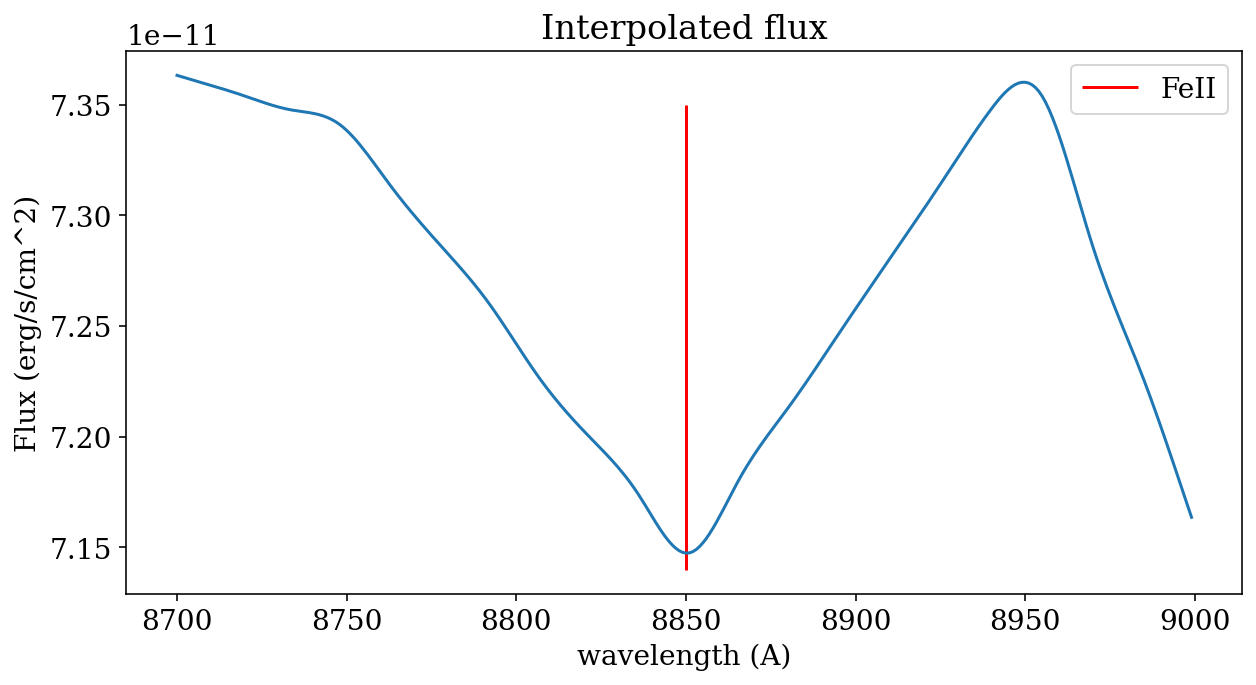

In [60]:
plt.plot(np.arange(8700,9000), interp_flux(np.arange(8700,9000)))
plt.title('Interpolated flux')
plt.xlabel('wavelength (A)')
plt.ylabel('Flux (erg/s/cm^2)')
plt.vlines(8850, 7.14e-11, 7.35e-11, label='FeII', colors='r')
plt.legend()

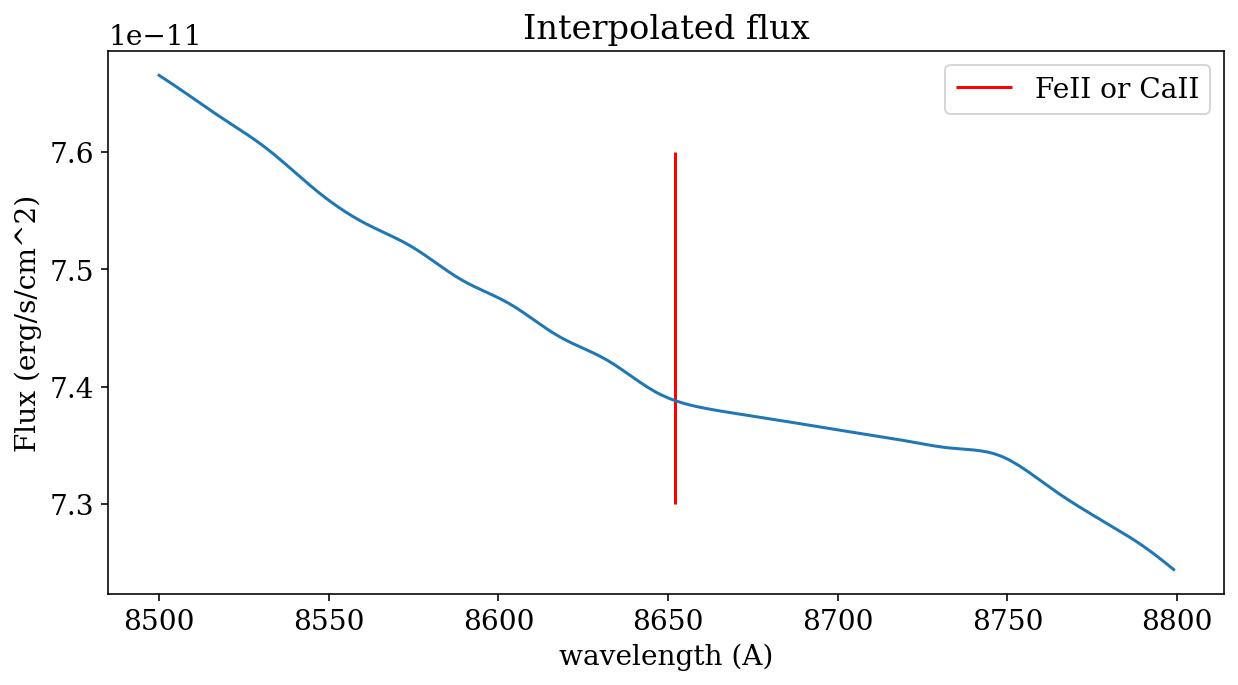

In [61]:
plt.plot(np.arange(8500,8800), interp_flux(np.arange(8500,8800)))
plt.title('Interpolated flux')
plt.xlabel('wavelength (A)')
plt.ylabel('Flux (erg/s/cm^2)')
plt.vlines(8652, 7.3e-11, 7.6e-11, label='FeII or CaII', colors='r')
plt.legend()

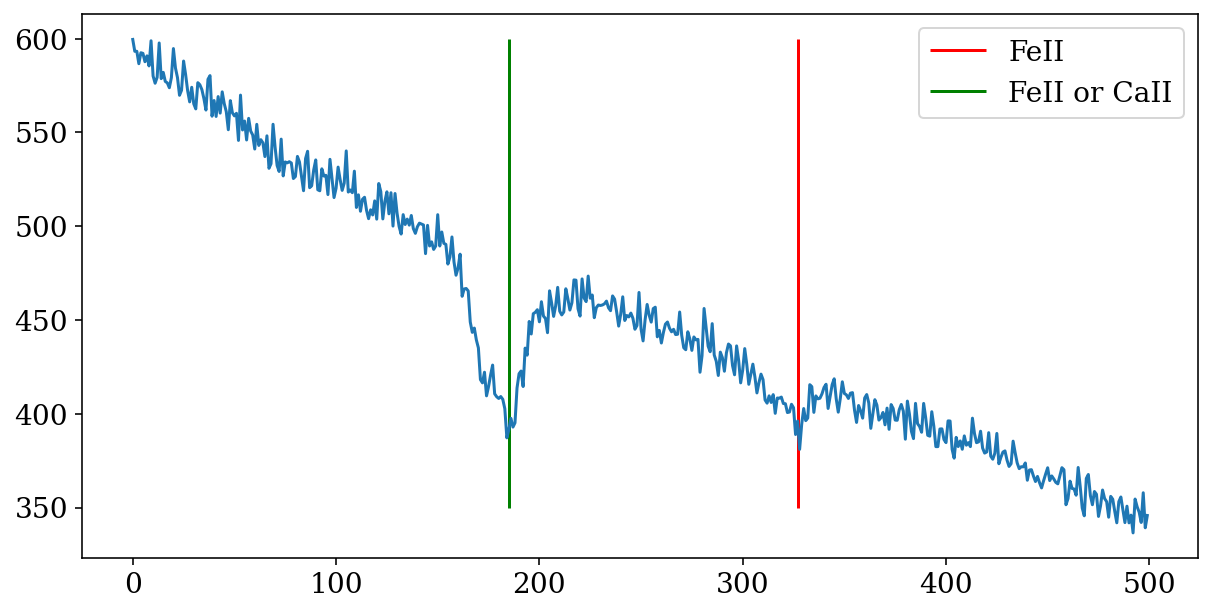

In [62]:
plt.plot(spc1d[2000:2500])
plt.vlines(327, ymin=350, ymax=600, label='FeII', colors='r')
plt.vlines(185, ymin=350, ymax=600, label='FeII or CaII', colors='g')
plt.legend()

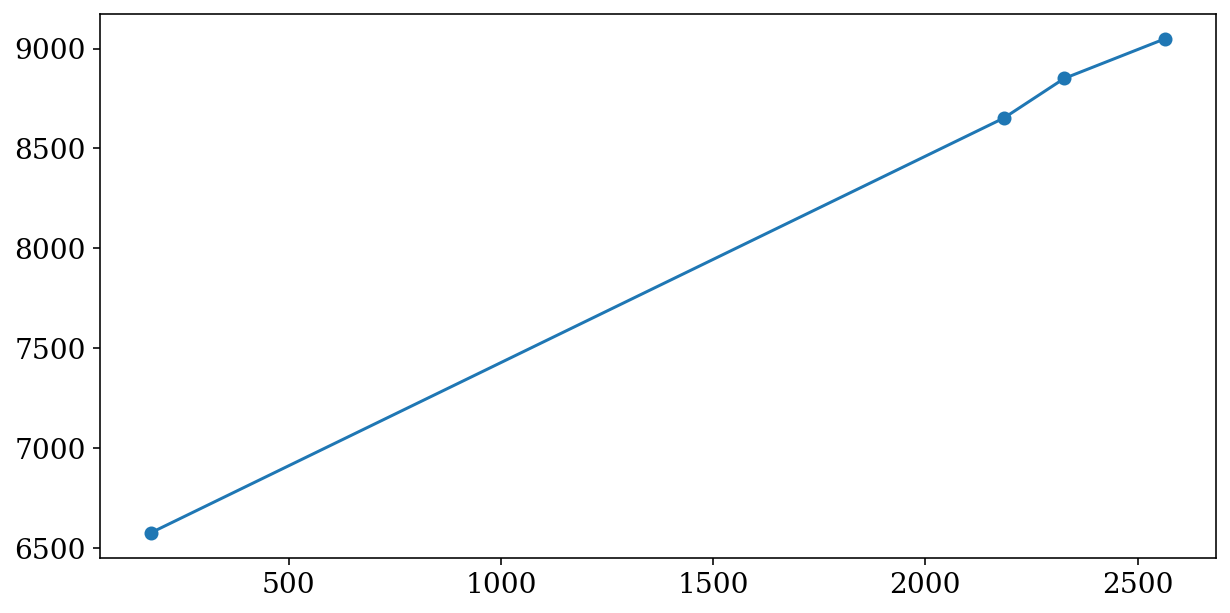

In [63]:
kwave = np.array([6576,8652,8850,9049])
xpix = np.array([175,2185,2327,2565])

plt.plot(xpix, kwave)
plt.scatter(xpix, kwave)